In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

from data.data import df_tr_log

#sns.set_style(style="ticks",rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})
sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

# Log Returns
$z_t = \log\big(\frac{p_t}{p_{t-1}}\big)$

In [9]:
len(df_tr_log)

2871

In [10]:
df_tr_log_red = pd.read_pickle("data/df_tr_log_red.pkl") #_red: 20 assets: BWGP+ZUS
len(df_tr_log_red)

2871

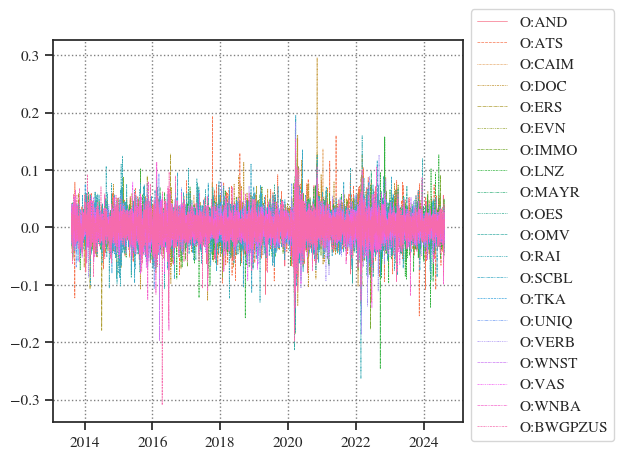

In [11]:
fig, ax = plt.subplots()
sns.lineplot(df_tr_log_red,linewidth=0.5,ax=ax)
plt.xlabel(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.1))
plt.tight_layout()

#fig.savefig("assets/log_returns.svg")

plt.show()

# Realized Portfolio Returns

<Axes: xlabel='DAY'>

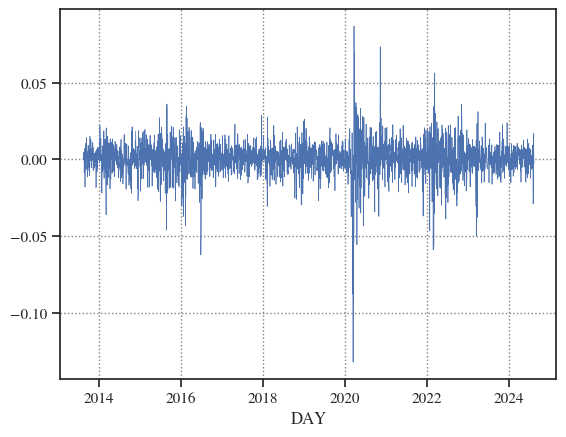

In [12]:
import pandas as pd
from data.data import df_tr_log_red

n = df_tr_log_red.shape[1]
w = np.array([1/n]*n)

mu_pf_real = np.sum(df_tr_log_red*w,axis=1)

sns.lineplot(mu_pf_real,linewidth=0.5)

#mu_pf_real.to_pickle("data/mu_pf.pkl")

# GARCH Volatility 1-Period Forecast
## GARCH(1,1)
$\sigma^2_t = \omega + \alpha_1 \epsilon^2_{t-1}+\beta_1 \epsilon^2_{t-2}$

With $\sigma^2_t$ representing the conditional variance of the error term at time $t$ <br>
and $\omega$ representing a constant unconditional variance <br>
and $\alpha_1$ and $\beta_1$ being coefficients for the squared error term $\epsilon^2$.

In [13]:
from tqdm import tqdm
import time
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from arch.univariate import ConstantMean, GARCH
from data.data import df_tr_log
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  O:AND   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                649.665
Distribution:                  Normal   AIC:                          -1291.33
Method:            Maximum Likelihood   BIC:                          -1277.24
                                        No. Observations:                  250
Date:                Fri, Nov 29 2024   Df Residuals:                      249
Time:                        13:00:43   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         

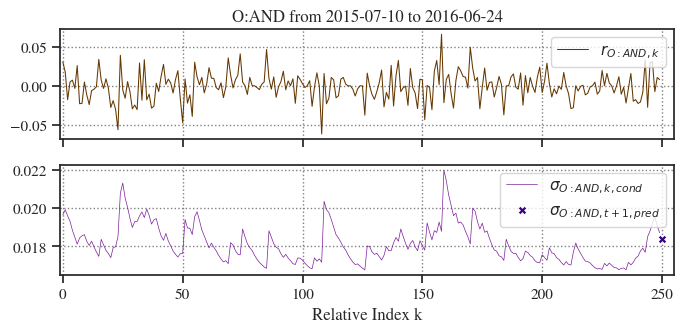

In [14]:
# Inspecting an arbitrary windowed GARCH(1,1) model
i = 500 #window number
t = 0 #ticker

ticker = df_tr_log.columns[t]
start_date = df_tr_log.index[i].strftime("%Y-%m-%d")
end_date = df_tr_log.index[i+250].strftime("%Y-%m-%d")

example_window = df_tr_log.iloc[i:i+250,t]

am = ConstantMean(example_window,rescale=False)
am.volatility = GARCH(p=1,q=1)

garch1_1 = am.fit(disp=False)
print(garch1_1.summary)

cond_vol = garch1_1.conditional_volatility
forecast = np.sqrt(garch1_1.forecast(horizon=1).variance.values[0]) #forecast from window 500 = \sigma_{t,i+250,pred}
forecast_series = [*[np.nan for _ in range(250)],forecast]

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(7, 3.5))
axs[0].set_title(f"{ticker} from {start_date} to {end_date}")
sns.lineplot(example_window.values,ax=axs[0],color="xkcd:brown",linewidth=0.75,label=r"$r_{O:AND,k}$")
sns.lineplot(cond_vol.values,ax=axs[1],color="xkcd:purple",linewidth=0.5,label=r"$\sigma_{O:AND,k,cond}$")
sns.scatterplot(x=250,y=forecast,ax=axs[1],marker="X",color="xkcd:indigo",label=r"$\sigma_{O:AND,t+1,pred}$")

axs[1].set_xlabel("Relative Index k")

sns.move_legend(axs[0], "upper right")

plt.tight_layout()
plt.xlim(left=-1,right=255)

#fig.savefig("assets/garch_window.svg")

plt.show()

In [15]:
nc = 0 #Counts ConvergenceWarnings
n = 0 #Counts the total number of windows

def garch_vol(window):
    """
    Pandas rolling callback function: Predicts the GARCH volatility on a cetrain day based on the last len(window) observations.
    If the solver can't converge it uses EWMA(0.94).
    Returns sqrt(var) = std 
    """
    global n
    global nc
    
    assert len(window) == 250
    
    n += 1

    am = ConstantMean(window,rescale=False)
    am.volatility = GARCH(p=1,q=1)
    res = am.fit(disp=False,show_warning=False)

    #If Convergence not succesful then apply EWMA estimation
    if not res._optim_output.success:
        nc += 1
        start, end = window.index[0].strftime("%Y-%m-%d"),window.index[-1].strftime("%Y-%m-%d")
        print(f"No Convergence for GARCH in {start} - {end}. Using EWMA!")
            
        am.volatility = EWMAVariance(0.94)
        res = am.fit(disp=False,show_warning=False)

    return np.sqrt(res.forecast(horizon=1).variance.values[0][0])

In [16]:
#Calculation
df_sigma = pd.DataFrame()
tickers = df_tr_log.columns

start_time = time.perf_counter()

#Sequential
#df_sigma = df_tr_log.rolling(250,closed="left").apply(garch_vol) #745 sec

#Parallel
def func(ticker):
    return ticker, df_tr_log.loc[:,ticker].rolling(250,closed="left").apply(garch_vol)

#with ProcessPoolExecutor() as p:
#    for ticker,res in tqdm(p.map(func,tickers),total=len(tickers)): #269 sec
#        df_sigma.loc[:,ticker] = res

end_time = time.perf_counter()

print(f"Total time: {end_time-start_time} sec.")

Total time: 0.00025579999964975286 sec.


In [17]:
#Align with returns and writing results to file

#df_sigma.loc[df_tr_log.index[0],:] = np.nan
#df_sigma.to_pickle("data/df_sigma_pred.pkl")

In [18]:
df_sigma_pred = pd.read_pickle("data/df_sigma_pred.pkl")
df_sigma_pred.shape

(2871, 20)

The mean standard deviation of n samples with equal length and individual standard deviations $\sigma_i$ is given by <br>
$\bar{\sigma} = \sqrt{\frac{\sum{\sigma_i^2}}{n}}$

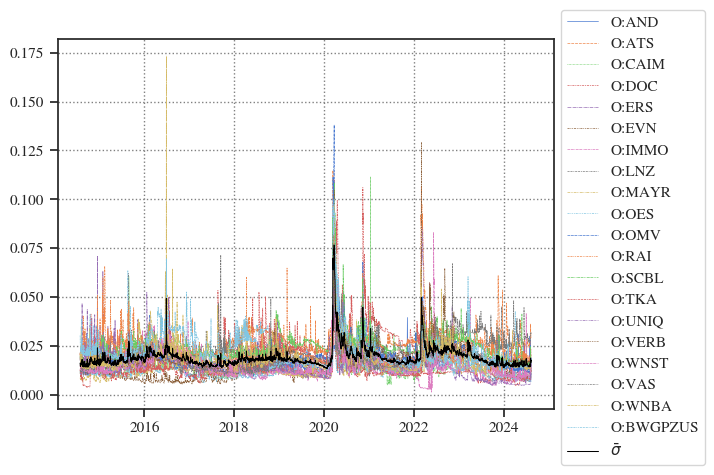

In [19]:
#Abb. each day's predicted volatilites for every asset
#TODO plot vs mean std

def mean_std(row):
    return np.sqrt(sum(map(lambda x: x**2,row))/len(row))

df_sigma_pred.loc[:,"mean_std"] = df_sigma_pred.apply(mean_std,axis=1)

fig,ax = plt.subplots()
sns.lineplot(df_sigma_pred.iloc[:,:-1],ax=ax,linewidth=0.5,palette="muted")
sns.lineplot(df_sigma_pred.iloc[:,-1],ax=ax,linewidth=0.75,color="xkcd:black",label=r"$\bar{\sigma}$")
plt.xlabel(None)
plt.ylabel(None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.1))

#fig.savefig("assets/predicted_volatilities.svg",bbox_inches="tight")

plt.show()

# Volatility Adjustment of Daily Returns

In [20]:
# 1) Calculating the adjustment factors until the last 250
#df_adj_factors = df_sigma_pred.shift(-250,fill_value=np.nan) / df_sigma_pred

In [21]:
# 2) Filling the adjustment facotrs for the last 250 elements
#df_adj_factors.iloc[-250:] = df_sigma_pred.iloc[-1]/df_sigma_pred.iloc[-250:]

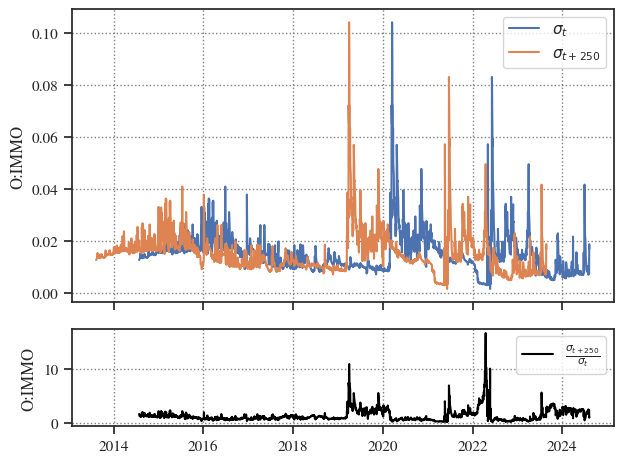

In [22]:
#Investigation
df_adj_factors = pd.read_pickle("data/df_adj_factors.pkl")

date = "2022-04-18"
ticker = "O:IMMO"


fig,axs = plt.subplots(nrows=2,height_ratios=(3,1),sharex=True)
sns.lineplot(df_sigma_pred.loc[:,ticker],label=r"$\sigma_t$",ax = axs[0])
sns.lineplot(df_sigma_pred.shift(-250).loc[:,ticker],label=r"$\sigma_{t+250}$",ax = axs[0])

sns.lineplot(df_adj_factors.loc[:,ticker],label=r"$\frac{\sigma_{t+250}}{\sigma_t}$",ax = axs[1],color="black")

plt.xlabel(None)
plt.tight_layout()
plt.show()


- We produce n windows each of length 250 and adjust the returns within each of these windows with $r_{t,adj} = r_t \frac{\sigma_{250}}{\sigma_t}$, so that the last element in each seperate window is adjusted by the factor 1
- This results in an array of n windows to apply all further calculations on

In [23]:
df_r = pd.read_pickle("data/df_tr_log_red.pkl")
df_sigma = pd.read_pickle("data/df_sigma_pred.pkl")
df_r.shape, df_sigma.shape

((2871, 20), (2871, 20))

In [24]:
#Dividing into windows
r_windows = sliding_window_view(df_r,(250,20)).squeeze(1)
sigma_windows = sliding_window_view(df_sigma,(250,20)).squeeze(1)
r_windows.shape, sigma_windows.shape

((2622, 250, 20), (2622, 250, 20))

In [25]:
#Vectorized Caclulation of adjustment facors windows: adj.factor for each elemnt
adj_factor_windows = np.array([window[-1]/window for window in sigma_windows])

In [26]:
#Adjusted Returns windows: Multiplying each return in each window with its corresponding adj. factor
adj_return_windows = r_windows*adj_factor_windows

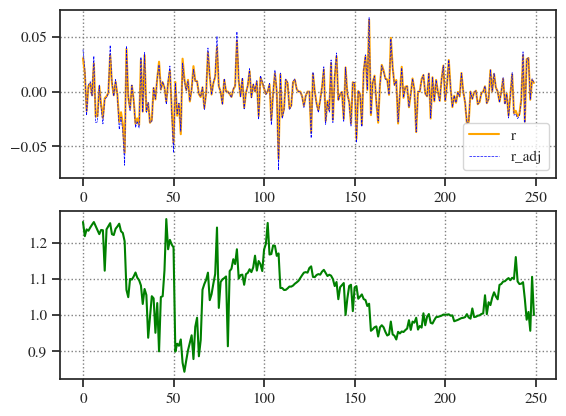

In [27]:
#Test
i = 500
i_a = 0

adj_r = pd.DataFrame(adj_return_windows[i]).iloc[:,i_a] 
adj_f = pd.DataFrame(adj_factor_windows[i]).iloc[:,i_a]
r = pd.DataFrame(r_windows[i]).iloc[:,i_a]

fig, axs = plt.subplots(nrows=2)

sns.lineplot(r,ax=axs[0],label="r",color="orange")
sns.lineplot(adj_r, ax=axs[0],color="blue",label="r_adj",linewidth=0.5,linestyle="--")
sns.lineplot(adj_f, ax=axs[1],color="green")

for ax in axs:
    #ax.set_xlim(45,55)
    ax.set_ylabel(None)

assert np.all(adj_r == adj_f*r)

In [28]:
#np.save("data/adj_return_windows.npy",adj_return_windows)
#np.save("data/adj_factor_windows.npy",adj_factor_windows)

In [29]:
#Investigation
#adj_return_windows = np.load("data/adj_return_windows.npy")
#adj_factor_windows = np.load("data/adj_factor_windows.npy")
#adj_return_windows.shape, adj_factor_windows.shape

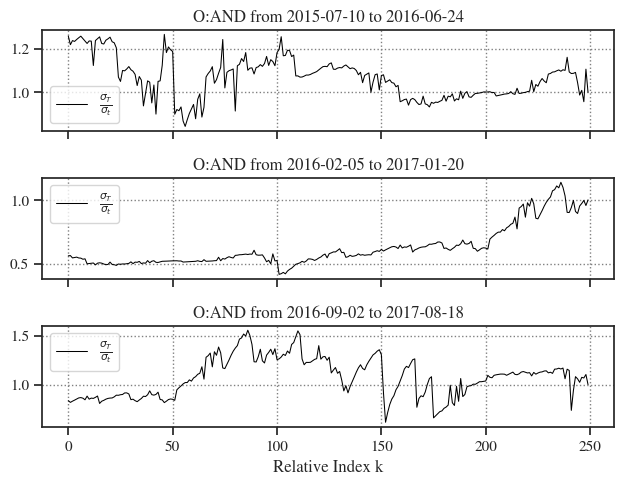

In [30]:
#Adjustment Factors for windows

from data.data import adj_factor_windows, adj_return_windows

fig, axs = plt.subplots(nrows=3,sharex=True)
for i,i_w in enumerate([500,650,800]):
    window = adj_factor_windows[i_w]
    series = window[:,0]
    ticker = df_tr_log.columns[0]
    sns.lineplot(series,linewidth=0.75,color="black",ax=axs[i],label=r"$\frac{\sigma_T}{\sigma_t}$")
    start = df_tr_log.index[i_w].strftime("%Y-%m-%d")
    end = df_tr_log.index[i_w+250].strftime("%Y-%m-%d")
    axs[i].set_title(f"{ticker} from {start} to {end}")

plt.tight_layout()
axs[2].set_xlabel("Relative Index k")

#fig.savefig("assets/adj_factor_windows.svg")

plt.show()

In [31]:
from numpy.lib.stride_tricks import sliding_window_view

df_tr_log_red = pd.read_pickle("data/df_tr_log_red.pkl")
r_windows = sliding_window_view(df_tr_log_red,(250,20)).squeeze(1)

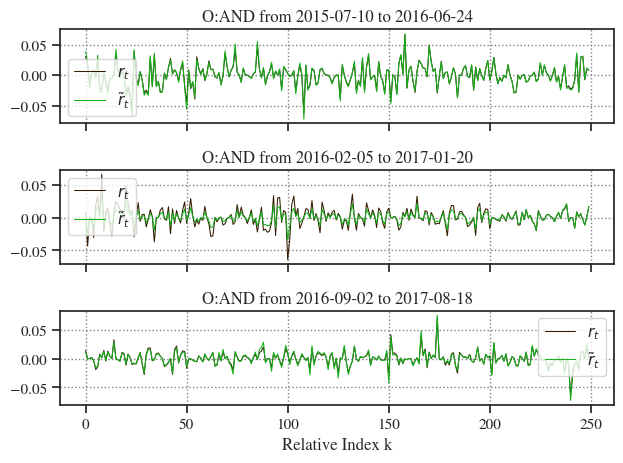

In [32]:
#Return vs. adj. Return for an asset

fig, axs = plt.subplots(nrows=3,sharex=True)
for i,i_w in enumerate([500,650,800]):
    r_window = r_windows[i_w]
    adj_r_window = adj_return_windows[i_w]
    r_series = r_window[:,0]
    adj_r_series = adj_r_window[:,0]
    ticker = df_tr_log.columns[0]
    
    sns.lineplot(r_series,linewidth=0.75,color="xkcd:dark brown",ax=axs[i],label=r"$r_t$")
    sns.lineplot(adj_r_series,linewidth=0.75,ax=axs[i],color="xkcd:green",label=r"$\tilde{r}_t$")
    start = df_tr_log.index[i_w].strftime("%Y-%m-%d")
    end = df_tr_log.index[i_w+250].strftime("%Y-%m-%d")
    axs[i].set_title(f"{ticker} from {start} to {end}")

axs[2].set_xlabel("Relative Index k")
plt.tight_layout()

#fig.savefig("assets/adj_return_windows.svg")

plt.show()

# Variance-Covariance Model

In [33]:
df_tr_adj = pd.read_pickle("data/df_tr_adj.pkl")
df_tr_adj.shape

(2871, 20)

In [34]:
from models.VarianceCovariance import expected_portfolio_mu, expected_quantile
from tools.Portfolio import mu as mu_pf, std as std_pf

In [35]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
mu_pf_exp = expected_portfolio_mu(df_tr_adj)
sigma_pf_exp = std_pf(df_tr_adj)

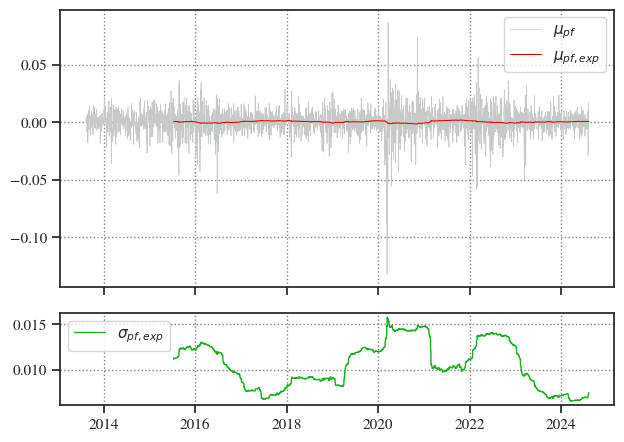

In [36]:
fig, axs = plt.subplots(nrows=2,height_ratios=(3,1),sharex=True)

sns.lineplot(mu_pf,ax=axs[0],label=r"$\mu_{pf}$",linewidth=0.5,color="xkcd:silver")
sns.lineplot(mu_pf_exp,ax=axs[0],linewidth=0.75,label=r"$\mu_{pf,exp}$",color="xkcd:red")

sns.lineplot(sigma_pf_exp,ax=axs[1],label=r"$\sigma_{pf,exp}$",linewidth=1,color="xkcd:green")
plt.tight_layout()
plt.xlabel(None)
plt.show()

In [37]:
#Quantile
q_exp = expected_quantile(mu_pf_exp,sigma_pf_exp)

#save to file
#q_exp.to_pickle("data/var_cov.pkl")

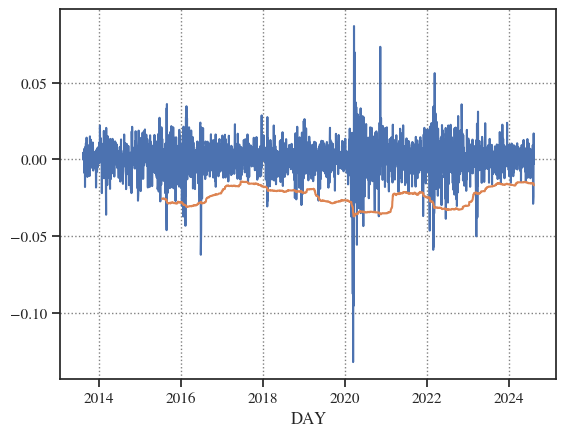

In [38]:
sns.lineplot(mu_pf)
sns.lineplot(q_exp)

plt.show()

In [39]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
#var_cov = pd.read_pickle("data/var_cov.pkl")
var_cov = q_exp

start=var_cov.dropna().index[0]
end=mu_pf.index[-1]

hits = mu_pf.loc[start:end] < var_cov.loc[start:end]
sum(hits)/len(hits)

0.017306880540312368

### Quantile

In [40]:
from scipy.stats import norm
from data.data import adj_factor_windows

#adj_return_windows = np.load("data/adj_return_windows.npy")
len(adj_return_windows)

2622

In [41]:
def get_mu_pf(window:np.array,weights=None):
    n = window.shape[1]

    assert len(window) == 250
    
    if not weights:
        weights = np.array([1/n]*n)
    return np.mean(np.sum(window*weights,axis=1)) #vecorized for speed

def get_sigma_pf(window:np.array,weights=None):
    n = window.shape[1]
    if not weights:
        weights = np.array([1/n]*n)
    cov = np.cov(window,rowvar=False)
    return np.sqrt(weights.T.dot(cov).dot(weights))

def quantile(window,weights=None,alpha=0.01): #quantiles
    mu = get_mu_pf(window,weights=weights)
    sigma = get_sigma_pf(window,weights=weights)
    return norm.ppf(alpha,loc=mu,scale=sigma)


In [42]:
quantiles = [quantile(window) for window in adj_return_windows]
len(quantiles)

2622

In [43]:
#Aligning with date scale
pre = np.array([np.nan]*250)
aligned_quantiles = np.append(pre,quantiles)

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

var_cov_2 = pd.Series(aligned_quantiles,index=index)

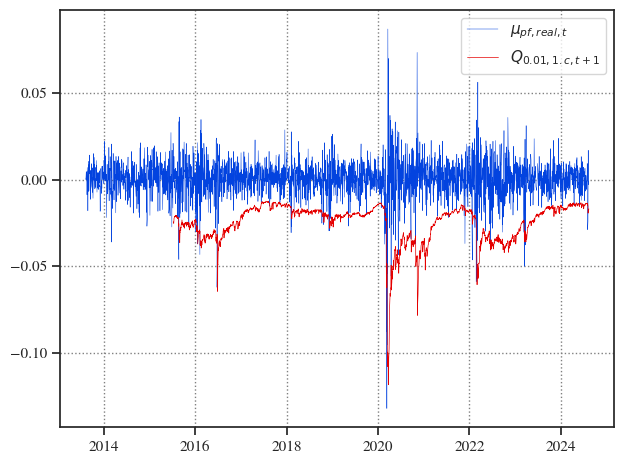

In [44]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
var_cov_2 = pd.read_pickle("data/var_cov_v2.pkl")

fig, ax = plt.subplots()
sns.lineplot(mu_pf,linewidth=0.35,color="xkcd:blue",label=r"$\mu_{pf,real,t}$")
sns.lineplot(var_cov_2,linewidth=0.5,color="xkcd:red",label=r"$Q_{0.01,1.c,t+1}$")
plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/var_cov.svg")
plt.show()

In [45]:
#hits vs unadjusted realized portfolio returns
start=var_cov_2.dropna().index[0]
end=mu_pf.index[-1]
hits = mu_pf[start:end]<var_cov_2[start:end]
sum(hits)/len(hits)

0.019831223628691982

In [46]:
#var_cov_2.to_pickle("data/var_cov_v2.pkl")

### Expected Shortfall
With VaR in mind, we can define the Conditional VAR, or CVaR or Expected Shortfall by
$$CVaR_{h, \alpha}(X) = -E(X|X < x_{h, \alpha}) = \frac{1}{\alpha}\int_{-\infty}^{Q_{\alpha}} x f(x)dx$$ 
Intepretation of this is simple. Basically, it's the expected (mean) value of X, given that X is more than x at a specified alpha. <br>
see, e.g. McNeil at al, 2015, pp. 44-45

In [47]:
from scipy.stats import norm
from scipy.integrate import quad
from data.data import adj_return_windows
#adj_return_windows = np.load("data/adj_return_windows.npy")

def expected_shortfall(window,weights=None,alpha=0.01):
    mu = get_mu_pf(window,weights=weights)
    sigma = get_sigma_pf(window,weights=weights)
    var = mu + norm.ppf(alpha)*sigma

    def integrand(x):
        return x*(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)**2/(2*sigma**2)))

    I =  1/alpha * quad(integrand,-np.inf,var)[0]
    ES = mu - sigma*norm.pdf(norm.ppf(alpha))/(alpha)

    return var,I,ES

In [48]:
window = adj_return_windows[251]
expected_shortfall(window)

(-0.02438458934435001, -0.027952049613884637, -0.027952049613884606)

In [49]:
norm.pdf(norm.ppf(0.01))

0.02665214220345808

In [50]:
es = [expected_shortfall(window)[1] for window in adj_return_windows]
len(es)

/tmp/ipykernel_46001/327977906.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I =  1/alpha * quad(integrand,-np.inf,var)[0]


2622

In [51]:
#Aligning with date scale
pre = np.array([np.nan]*250)
aligned_shortfalls = np.append(pre,es)

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

es_cov_2 = pd.Series(aligned_shortfalls,index=index)

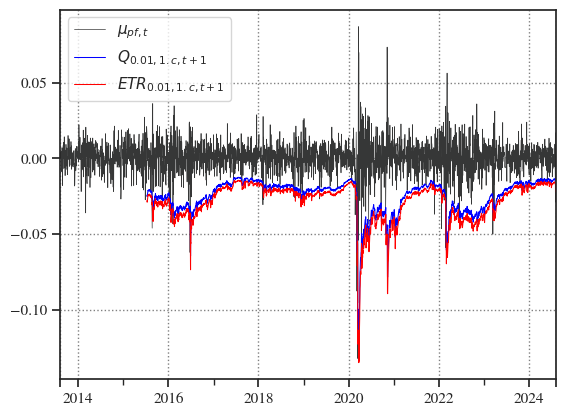

In [52]:
var_cov_2 = pd.read_pickle("data/var_cov_v2.pkl")

fig, ax = plt.subplots()

mu_pf.plot(color="xkcd:dark grey",linewidth=0.5,label=r"$\mu_{pf,t}$",ax=ax)
var_cov_2.plot(color="blue",label=r"$Q_{0.01,1.c,t+1}$",linewidth=0.75,ax=ax)
es_cov_2.plot(color="red",label=r"$ETR_{0.01,1.c,t+1}$",linewidth=0.75)

plt.legend()
plt.xlabel(None)

#fig.savefig("assets/var_es_cov.svg")

plt.show()

In [53]:
#es_cov_2.to_pickle("data/es_cov_v2.pkl")

# Historical Simulation

### Quantile

In [54]:
from data.data import adj_return_windows

#adj_return_windows = np.load("data/adj_return_windows.npy")

In [55]:
def quantile(window:np.array,weights=None,alpha=0.01):
    n = window.shape[1]
    if not weights:
        weights = np.array([1/n]*n)
    
    mu_pfs = np.sum(weights*window,axis=1)
    return np.quantile(mu_pfs,alpha)

In [56]:
quantiles = [quantile(window) for window in adj_return_windows]

In [57]:
#Aligning
pre = np.array([np.nan]*250)
aligned_quantiles = np.append(pre,quantiles)

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

var_hist_2 = pd.Series(aligned_quantiles,index=index)

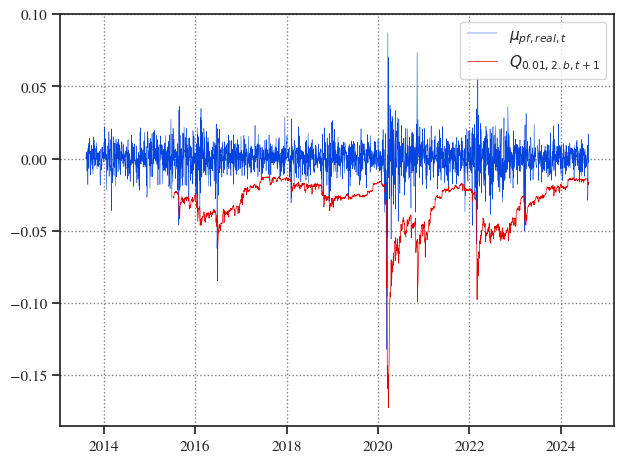

In [58]:
fig, ax = plt.subplots()

var_hist_2 = pd.read_pickle("data/var_hist_v2.pkl")

sns.lineplot(mu_pf,linewidth=0.35,color="xkcd:blue",label=r"$\mu_{pf,real,t}$")
sns.lineplot(var_hist_2,linewidth=0.5,color="xkcd:red",label=r"$Q_{0.01,2.b,t+1}$")
plt.xlabel(None)
plt.tight_layout()
sns.move_legend(ax,"upper right")
#fig.savefig("assets/var_hist.svg")
plt.show()

In [59]:
start = var_hist_2.dropna().index[0]
end=mu_pf.index[-1]
hits = mu_pf[start:end]<var_hist_2[start:end]
sum(hits)/len(hits)

0.014345991561181435

In [60]:
#var_hist_2.to_pickle("data/var_hist_v2.pkl")

### Expected Shortfall
non-parametric: Mean of all 250 mu_pf realizations that are smaller than the 0.01-quantile;
Acerbi and Tasche, 2002, p. 383 define the natural estimator for ES as average of the least alpha % outcomes of a random variable X (here: adj. returns)

In [61]:
def expected_shortfall(window:np.array,weights=None,alpha=0.01):
    n = window.shape[1]
    if not weights:
        weights = np.array([1/n]*n)
    
    mu_pfs = np.sum(weights*window,axis=1)
    var = np.quantile(mu_pfs,alpha)
    return np.mean(mu_pfs,where=mu_pfs<var)

In [62]:
es = [expected_shortfall(window) for window in adj_return_windows]
len(es)

/home/marcus/miniconda3/envs/ba/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marcus/miniconda3/envs/ba/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2622

In [63]:
#Aligning
pre = np.array([np.nan]*250)
aligned_shortfalls = np.append(pre,es)

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

es_hist_2 = pd.Series(aligned_shortfalls,index=index)

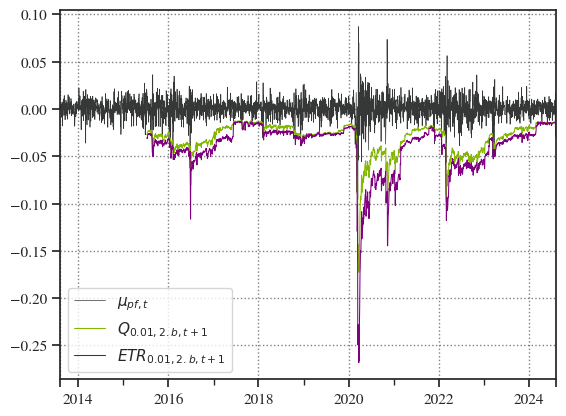

In [64]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
var_hist = pd.read_pickle("data/var_hist_v2.pkl")
es_hist = pd.read_pickle("data/es_hist_v2.pkl")

fig, ax = plt.subplots()

mu_pf.plot(label=r"$\mu_{pf,t}$",color="xkcd:dark grey",linewidth=0.5,ax=ax)
var_hist.plot(label=r"$Q_{0.01,2.b,t+1}$",color="xkcd:dark lime",linewidth=0.75,ax=ax)
es_hist.plot(label=r"$ETR_{0.01,2.b,t+1}$",color="purple",linewidth=0.75,ax=ax)

ax.set_xlabel(None)

plt.legend()

#fig.savefig("assets/var_es_hist.svg")

plt.show()

In [65]:
#es_hist_2.to_pickle("data/es_hist_v2.pkl")

# Normal Copula MLE
## Pseudo-Observations

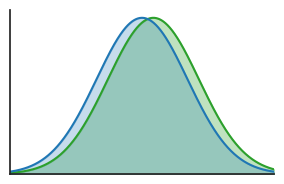

In [66]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.stats import norm
import math as m
import seaborn as sns 

fig, ax = plt.subplots(figsize=(3,2))

mu = 0
sigma = 1

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
n1 = norm.pdf(x, mu, sigma)
n2 = norm.pdf(x, mu+0.25,sigma)

plt.plot(x,n2,color="tab:green",linewidth=1.5)
plt.fill_between(x,0,n2,color="tab:green",alpha=0.3)

plt.plot(x,n1,color="tab:blue",linewidth=1.5)
plt.fill_between(x,0,n1,color="tab:blue",alpha=0.25)

sns.despine()
plt.ylabel(None)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlim(-2.9,2.9)
ax.set_ylim(bottom=0)
plt.tight_layout()
#fig.savefig("assets/gauss_distribution.svg",transparent=True)
plt.show()

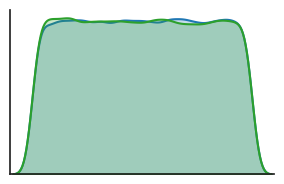

In [67]:
fig, ax = plt.subplots(figsize=(3,2))
u1 = np.random.uniform(size=100000)
u2 = np.random.uniform(size=100000)

sns.kdeplot(u1,color="tab:blue",fill=True,linewidth=1.5)
sns.kdeplot(u2,color="tab:green",fill=True,linewidth=1.5)

sns.despine()
plt.ylabel(None)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlim(-0.1,1.1)
plt.tight_layout()
#fig.savefig("assets/uniform_distribution.svg",transparent=True)
plt.show()

In [68]:
import rpy2.robjects as r
from rpy2.robjects.packages import importr
from tools.Converter import CONVERTER

In [69]:
r_copula = importr("copula")

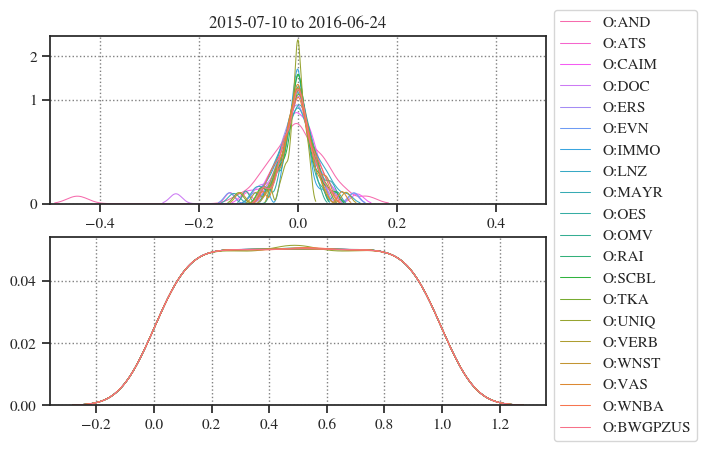

In [70]:
from data.data import adj_return_windows

adj_return_windows = np.load("data/adj_return_windows.npy")
df_tr = pd.read_pickle("data/df_tr_log_red.pkl")

i_w = 500
tickers = list(df_tr.columns)

start = df_tr.index[i_w].strftime("%Y-%m-%d")
end = df_tr.index[i_w+250].strftime("%Y-%m-%d")

with CONVERTER():
    pobs = r_copula.pobs(adj_return_windows[i_w])

fig, axs = plt.subplots(nrows=2)

sns.kdeplot(adj_return_windows[i_w],ax=axs[0],linewidth=0.75)
sns.kdeplot(pobs,ax=axs[1],linewidth=0.75,legend=False)

axs[0].set_ylabel(None)
axs[1].set_ylabel(None)

axs[0].set_yscale("function",functions=[lambda x: x**(1/2),lambda x: x])

axs[0].set_xlim(-0.5,0.5)


axs[0].legend(labels=tickers)
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1.2))

axs[0].set_title(f"{start} to {end}")


#fig.savefig("assets/kde_orig_pobs.svg",bbox_inches="tight")

plt.show()

In [72]:
from models.Copulae import normalCopulaSimulation, CopulaSimulation
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [73]:
df_tr_adj = pd.read_pickle("data/df_tr_adj.pkl")

#Creating window views to iterate over
window_shape = (250,df_tr_adj.shape[1])
windows_v1 = sliding_window_view(df_tr_adj,window_shape).squeeze(1)

windows_v1.shape

(2622, 250, 20)

In [74]:
def getCopulaParams(window:np.array,copula:CopulaSimulation):
    """
    Function that returns the copula params of a copula fitted to {window}.
    Returns a R float vector datatype to directly use with the R copula package within python.
    """
    if np.any(np.isnan(window)):
        return np.nan
    try:
        copula.fit(window,pseudo=True)
    except RRuntimeError as r_error:
        return np.nan
    else:
        return copula._params

In [75]:
max_ = windows_v1.shape[0] #Number of iterations

#Set the copula object to fit the data on
copula = normalCopulaSimulation(dispstr="un",method="mpl") #Use a gauss Copula

start_time = time.perf_counter()

#Parallel Computation
#with ProcessPoolExecutor() as p:
#    params = [P_G for P_G in tqdm(p.map(partial(getCopulaParams,copula=copula),windows_v1),total=max_)]
        
end_time = time.perf_counter()

#df_normal_copula_mle_params = pd.Series(params)

#Save results as byte-file to disk
#df_normal_copula_mle_params.to_pickle("data/normal_copula_mle_params.pkl")

#Write performance measures to file
#with open("data/normal_copula_calibration_metrics.txt","w") as f:
#    f.write(f"Calculations: {max_}\nTime[s]: {end_time-start_time}")

Using the array with individual windows of adjusted returns

In [76]:
from data.data import adj_return_windows as windows_v2

#windows_v2 = np.load("data/adj_return_windows.npy")
windows_v2.shape

(2622, 250, 20)

In [77]:
max_ = windows_v2.shape[0] #Number of iterations

#Set the copula object to fit the data on
copula = normalCopulaSimulation(dispstr="un",method="mpl") #Use a gauss Copula

start_time_1 = time.perf_counter()

#Parallel Computation
#with ProcessPoolExecutor() as p:
#    params1 = [P_G for P_G in tqdm(p.map(partial(getCopulaParams,copula=copula),windows_v2[:1311]),total=1311)]

end_time_1 = time.perf_counter()
print(f"First completed in {end_time_1-start_time_1}. Manually continue with 2nd half!")

First completed in 6.479999865405262e-05. Manually continue with 2nd half!


In [78]:
#Save intermediate result to disk
#pd.Series(params1).to_pickle("temp/params1.pkl")

In [79]:
start_time_2 = time.perf_counter()

#with ProcessPoolExecutor() as p:
#    params2 = [P_G for P_G in tqdm(p.map(partial(getCopulaParams,copula=copula),windows_v2[1311:]),total=1311)]
        
end_time_2 = time.perf_counter()
print(f"Second completed in {end_time_2-start_time_2}. Write to file!")

#Save 2nd half
#pd.Series(params2).to_pickle("temp/params2.pkl")

Second completed in 6.550000034621917e-05. Write to file!


In [81]:
#Appending and saving
s_params1 = pd.read_pickle("temp/params1.pkl")
s_params2 = pd.read_pickle("temp/params2.pkl")

normal_copula_mle_params_2 = pd.concat([s_params1,s_params2],ignore_index=True)

In [82]:
#Saving to disk
#normal_copula_mle_params_2.to_pickle("data/normal_copula_mle_params_v2.pkl")

## Quantiles

In [86]:
from models.Copulae import normQuantile

copula_params_v2 = pd.read_pickle("data/normal_copula_mle_params_v2.pkl").to_numpy()
windows_v2 = np.load("data/adj_return_windows.npy")

In [87]:
copula_params_v2.shape,windows_v2.shape

((2622,), (2622, 250, 20))

In [89]:
#Calculation
N_SIMS = 1e5
start_norm = time.perf_counter()

#with ProcessPoolExecutor() as p: #664 sec margin emp., 778 sec margin norm, 8188 sec margin t df bzw. f0=3; 8573 sec margin t df=free
    #var_norm_mle_v2 = [q for q in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="norm",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_norm_mle_v2 = [q for q in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="emp",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_norm_mle_v2 = [q for q in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="t",f0=3,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_norm_mle_v2 = [q for q in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="t",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    

end_norm = time.perf_counter()

print(f"1e5 Simulations from {len(windows_v2)} normal copulae [sec]: {end_norm-start_norm}")

1e5 Simulations from 2622 normal copulae [sec]: 0.02149780100080534


In [ ]:
len(var_norm_mle_v2)

In [ ]:
#align with realized portfolio returns
#var is an estimator for the next days realized return
#window[0] is from [0:250(excl)] -> means var[0] must be aligned with return[250]

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
var_norm_mle_v2_s = pd.Series(np.append(pre,var_norm_mle_v2),index=index)


#var_norm_mle_v2_s.to_pickle("data/var_norm_mle_v2_margin_norm.pkl")

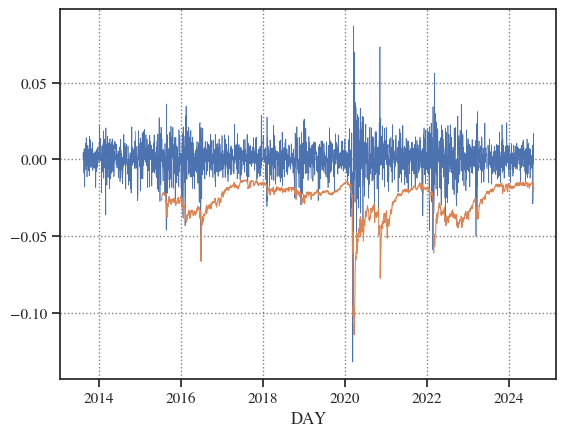

In [19]:
sns.lineplot(mu_pf,linewidth=0.5)
sns.lineplot(var_norm_mle_v2_s,linewidth=0.75)

plt.show()

In [20]:
start = var_norm_mle_v2_s.dropna().index[0]
end = mu_pf.index[-1]
hits = mu_pf[start:end]<var_norm_mle_v2_s[start:end]
sum(hits)/len(hits)

0.014629049111807733

## Expected Shortfall
Monte Carlo Simulaiton Expectes Shortfall: Average of all exceedances of the 0.01%-quantile:

In [92]:
#Calculation
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
from models.Copulae import normQuantile
import pandas as pd
import numpy as np

from data.data import adj_return_windows as windows_v2

copula_params_v2 = pd.read_pickle("data/normal_copula_mle_params_v2.pkl").to_numpy()
#windows_v2 = np.load("data/adj_return_windows.npy")

N_SIMS = 1e5

#with ProcessPoolExecutor() as p: 
    #es_norm_mle_v2 = [es for es in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="emp",n=N_SIMS,shortfall=True),windows_v2,copula_params_v2),total=len(windows_v2))]
    #es_norm_mle_v2 = [es for es in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="norm",n=N_SIMS,shortfall=True),windows_v2,copula_params_v2),total=len(windows_v2))]
    #es_norm_mle_v2 = [es for es in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="t",n=N_SIMS,shortfall=True),windows_v2,copula_params_v2),total=len(windows_v2))]
    #es_norm_mle_v2 = [es for es in tqdm(p.map(partial(normQuantile,dispstr="un",distribution="t",f0=3,n=N_SIMS,shortfall=True),windows_v2,copula_params_v2),total=len(windows_v2))]

In [22]:
#align with realized portfolio returns

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
es_norm_mle_v2_s = pd.Series(np.append(pre,es_norm_mle_v2),index=index)


#es_norm_mle_v2_s.to_pickle("data/es_norm_mle_v2_margin_t_f0_3.pkl")

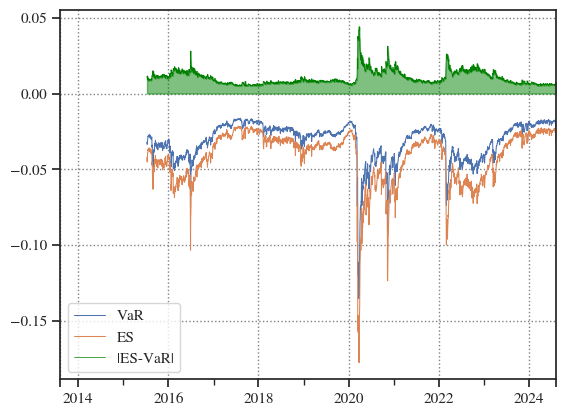

In [93]:
es_norm_mle_v2_x = pd.read_pickle("data/es_norm_mle_v2_margin_t_f0_3.pkl")
var_norm_mle_v2_x = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")

#mu_pf.plot(label="mu_pf",color="silver",linewidth=0.5)
var_norm_mle_v2_x.plot(label="VaR",linewidth=0.75)
es_norm_mle_v2_x.plot(label="ES",linewidth=0.75)

diff = abs(es_norm_mle_v2_x -var_norm_mle_v2_x)
diff.plot(color="green",linewidth=0.5,label="|ES-VaR|")
plt.fill_between(diff.index,diff.values,color="green",alpha=0.5)

plt.legend()
plt.show()

# Student-t Copula w/ gaussian MLE params
Uses the parameters from a previously fitted normal copula to calibrate a t-copula; then samples from this t-copula and calculates the 1%-quantile.
## Quantiles

In [36]:
from models.Copulae import tQuantile

In [ ]:
#Signature
#tQuantile(window,param,n=1e6,weights=None,**kwargs)
# copula_kwargs: dispstr = "un", df=3 passed to R copula.tCopula()
# margin_kwargs: distribution="t"|"n", f0=3 passed to Transformations.ppf_transform, scipy.stats.t|n.fit

In [94]:

N_SIMS = 1e5

start_t = time.perf_counter()

#with ProcessPoolExecutor() as p: #~8614 sec margin t f0=3; 8300 sec margin t f0(df)=var;1006 sec margin n; 940 sec margin emp.;
    #var_t_mle_v2 = [q for q in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="emp",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_t_mle_v2 = [q for q in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="norm",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_t_mle_v2 = [q for q in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="t",n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #var_t_mle_v2 = [q for q in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="t",f0=3,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]

end_t = time.perf_counter()

print(f"{N_SIMS} Simulations from {len(windows_v2)} normal copulae [sec]: {end_t-start_t}")

100000.0 Simulations from 2622 normal copulae [sec]: 5.760000021837186e-05


In [43]:
#align with realized portfolio returns
#var is an estimator for the next days realized return
#window[0] is from [0:250(excl)] -> means var[0] must be aligned with return[250]

mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
var_t_mle_v2_s = pd.Series(np.append(pre,var_t_mle_v2),index=index)


#var_t_mle_v2_s.to_pickle("data/var_t_mle_v2_margin_emp.pkl")

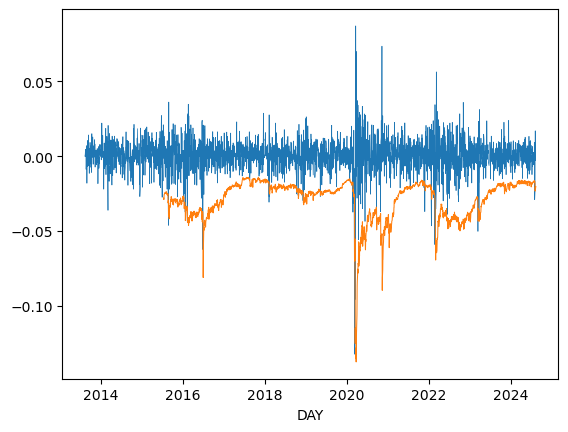

In [45]:

var_t_mle_v2_s = pd.read_pickle("data/var_t_mle_v2_margin_emp.pkl")
sns.lineplot(mu_pf,linewidth=0.5)
sns.lineplot(var_t_mle_v2_s,linewidth=0.75)

plt.show()

In [46]:
start = var_t_mle_v2_s.dropna().index[0]
end = mu_pf.index[-1]

hits = mu_pf[start:end]<var_t_mle_v2_s[start:end]

sum(hits)/len(hits) 

0.013924050632911392

## Expected Shortfall

### Version 2

In [1]:
from models.Copulae import tQuantile
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [11]:
from data.data import adj_return_windows as windows_v2

N_SIMS = 1e5

copula_params_v2 = pd.read_pickle("data/normal_copula_mle_params_v2.pkl").to_numpy()
#windows_v2 = np.load("data/adj_return_windows.npy")

with ProcessPoolExecutor() as p:
    #es_t_mle_v2 = [es for es in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="emp",shortfall=True,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #es_t_mle_v2 = [es for es in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="norm",shortfall=True,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    #es_t_mle_v2 = [es for es in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="t",shortfall=True,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]
    es_t_mle_v2 = [es for es in tqdm(p.map(partial(tQuantile,dispstr="un",df=3,distribution="t",f0=3,shortfall=True,n=N_SIMS),windows_v2,copula_params_v2),total=len(windows_v2))]


100%|█████████████████████████████████████████████████████████████████████████████| 2622/2622 [2:09:31<00:00,  2.96s/it]


In [12]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
es_t_mle_v2_s = pd.Series(np.append(pre,es_t_mle_v2),index=index)

#es_t_mle_v2_s.to_pickle("data/es_t_mle_v2_margin_t_f0_3.pkl")

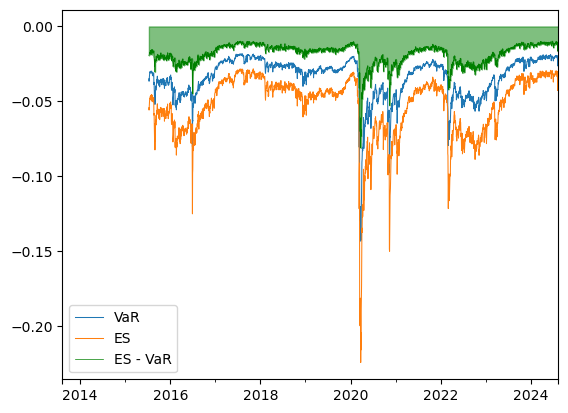

In [13]:
es_t_mle_v2_x = pd.read_pickle("data/es_t_mle_v2_margin_t_f0_3.pkl")
var_t_mle_v2_x = pd.read_pickle("data/var_t_mle_v2_margin_t_f0_3.pkl")

import matplotlib.pyplot as plt

#mu_pf.plot(label="mu_pf",color="silver",linewidth=0.5)
var_t_mle_v2_x.plot(label="VaR",linewidth=0.75)
es_t_mle_v2_x.plot(label="ES",linewidth=0.75)

diff = es_t_mle_v2_x - var_t_mle_v2_x
diff.plot(color="green",linewidth=0.5,label="ES - VaR")
plt.fill_between(diff.index,diff.values,color="green",alpha=0.5)

plt.legend()
plt.show()

# Normal Copula MoM

## Quantiles

In [154]:
from models.Copulae import CopulaSimulation, normalCopulaSimulation, tCopulaSimulation
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def func(data:np.array,copula:CopulaSimulation,how:str,n:int,weights=None,**margin_kwargs):
    """
    Fits a {copula} to the data, simulates {n}*2 realizations (inkl. antithetic variates).
    Simulation consists of Drawing {n} random samples, adding n antithetic variates to reduce
    the variance and then re-transforming to the scale of the margins, either parametric or empirical.
    Returns the 1%-quantile of all simulated portfolio returns.
    {margin_kwargs} are passed through to predict_parametric & scipy.stats.norm|t.fit
    Implemented {margin_kwargs} keys for predict_parametric are: 
    - 'distribution': 't'|'norm' which are passed through to predict_parametric

    Example
    A models.tCopulaSimulation instance fitted on {data} with t-margins where the samples are 
    re-transformed with each margin's distribution parameters: loc, scale and a fixed degree 
    of freedom of 3:
    
    func(data,tCopulaSimulation,n=1e3,weights=None,distribution='t',f0=3)
    """
    if np.any(np.isnan(data)):
        return np.nan
        
    dim = data.shape[1]
    if not weights:
        weights = np.array([1/dim]*dim)
    
    copula.fit(data)

    if how == "parametric":
        simulation = copula.predict_parametric(n=n,**margin_kwargs)
    elif how == "empirical":
        simulation = copula.predict_empirical(n=n)
    
    mu_pf = (weights*simulation).sum(axis=1)
    q = np.quantile(mu_pf,0.01)

    return q

In [8]:
df_tr_adj = pd.read_pickle("data/df_tr_adj.pkl")

#Creating window views to multiprocessing map
window_shape = (250,len(df_tr_adj.columns))
windows_v1 = sliding_window_view(df_tr_adj,window_shape).squeeze(1)

In [4]:
max_ = len(windows_v1)
N_SIMS = 1e5
normal_copula = normalCopulaSimulation(dispstr="un",method="irho")

start = time.perf_counter()

with ProcessPoolExecutor() as p: #728 sec
    var_norm_mom_v1 = [q for q in tqdm(p.map(partial(func,n=N_SIMS,copula=normal_copula),windows_v1),total=max_)]

end = time.perf_counter()

info = f"Calibrations: {max_}\nSimulations (Distribution Fitting): {max_} x {N_SIMS} x 2\nTime [s]: {end-start}"
print(info)

#with open("./data/gauss_copula_mom_metrics.txt","w") as f:
#    f.write(info)

100%|███████████████████████████████████████████████████████████████████████████████| 2622/2622 [12:07<00:00,  3.60it/s]


Calibrations: 2622
Simulations (Distribution Fitting): 2622 x 100000.0 x 2
Time [s]: 728.3275179529992


In [5]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
var_norm_mom_v1_s = pd.Series(np.append(pre,var_norm_mom_v1),index=index)


#var_norm_mom_v1_s.to_pickle("./data/var_norm_mom_v1.pkl")

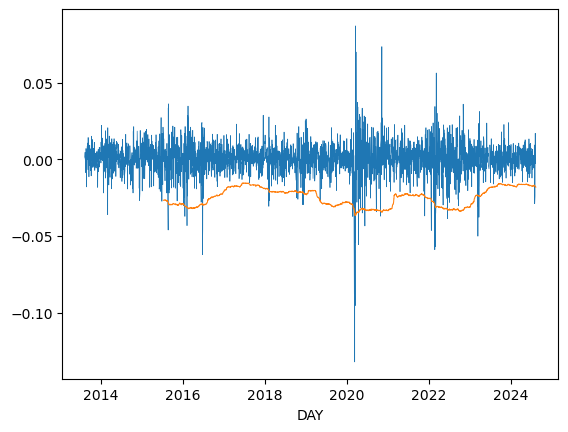

In [6]:
sns.lineplot(mu_pf,linewidth=0.5)
sns.lineplot(var_norm_mom_v1_s,linewidth=0.75)

plt.show()

In [7]:
start = var_norm_mom_v1_s.index[0]
end = mu_pf.index[-1]

hits = mu_pf[start:end]<var_norm_mom_v1_s[start:end]

sum(hits)/len(hits)

0.012887495646116336

In [ ]:
from data.data import adj_return_windows as windows_v2

#windows_v2 = np.load("data/adj_return_windows.npy")

max_ = len(windows_v2)
N_SIMS = 1e5
normal_copula = normalCopulaSimulation(dispstr="un",method="irho")

start = time.perf_counter()

with ProcessPoolExecutor() as p: #982 sec margin emp; 2600 sec margin t f0=3; 7760 sec margin t f0=var; 2032 sec margin pareto
    #var_norm_mom_v2_margin_emp = [q for q in tqdm(p.map(partial(func,how="parametric",n=N_SIMS,copula=normal_copula,distribution="norm"),windows_v2),total=max_)]
    #var_norm_mom_v2_margin_norm = [q for q in tqdm(p.map(partial(func,how="parametric",n=N_SIMS,copula=normal_copula,distribution="t"),windows_v2),total=max_)]
    #var_norm_mom_v2_margin_t = [q for q in tqdm(p.map(partial(func,how="empirical",n=N_SIMS,copula=normal_copula),windows_v2),total=max_)]
    #var_norm_mom_v2_margin_t_f0_3 = [q for q in tqdm(p.map(partial(func,how="parametric",distribution="pareto",n=N_SIMS,copula=normal_copula),windows_v2),total=max_)]


end = time.perf_counter()

info = f"Calibrations: {max_}\nSimulations (Distribution Fitting): {max_} x {N_SIMS} x 2\nTime [s]: {end-start}"
print(info)

#with open("./data/gauss_copula_mom_metrics.txt","w") as f:
#    f.write(info)

In [3]:
#HERE SAVE
mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
var_norm_mom_v2_s = pd.Series(np.append(pre,var_norm_mom_v2),index=index)


#var_norm_mom_v2_s.to_pickle("data/var_norm_mom_v2_margin_pareto.pkl")

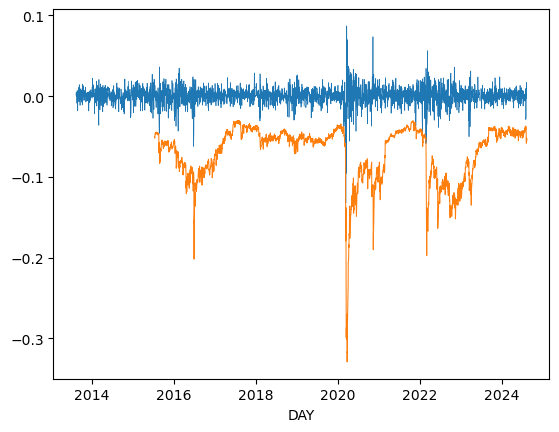

In [8]:
sns.lineplot(mu_pf,linewidth=0.5)
sns.lineplot(var_norm_mom_v2_s,linewidth=0.75)

plt.show()

In [9]:
start = var_norm_mom_v2_s.index[0]
end = mu_pf.index[-1]

hits = mu_pf[start:end]<var_norm_mom_v2_s[start:end]

sum(hits)/len(hits)

0.0010449320794148381

## Expected Shortfall

In [147]:
from models.Copulae import CopulaSimulation, normalCopulaSimulation, tCopulaSimulation
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def expected_shortfall(data:np.array,copula:CopulaSimulation,how:str,n:int,weights=None,**margin_kwargs):
    """
    Fits a {copula} to the data, simulates {n}*2 realizations (inkl. antithetic variates).
    Simulation consists of Drawing {n} random samples, adding n antithetic variates to reduce
    the variance and then re-transforming to the scale of the margins, either parametric or empirical.
    Returns the 1%-quantile of all simulated portfolio returns.
    {margin_kwargs} are passed through to predict_parametric & scipy.stats.norm|t.fit
    Implemented {margin_kwargs} keys for predict_parametric are: 
    - 'distribution': 't'|'norm' which are passed through to predict_parametric

    Example:
    A models.tCopulaSimulation instance fitted on {data} with t-margins where the samples are 
    re-transformed with each margin's distribution parameters: loc, scale and a fixed degree 
    of freedom of 3:
    
    func(data,tCopulaSimulation,"parametric",1e3,weights=None,distribution='t',f0=3)
    """
    if np.any(np.isnan(data)):
        return np.nan
        
    dim = data.shape[1]
    if not weights:
        weights = np.array([1/dim]*dim)
    
    copula.fit(data)

    if how == "parametric":
        simulation = copula.predict_parametric(n=n,**margin_kwargs)
    elif how == "empirical":
        simulation = copula.predict_empirical(n=n)
    
    mu_pf = (weights*simulation).sum(axis=1)
    q = np.quantile(mu_pf,0.01)
    es = np.mean(mu_pf,where=mu_pf<q)
    
    return es

In [155]:
from data.data import adj_return_windows as windows_v2

#windows_v2 = np.load("data/adj_return_windows.npy")

max_ = len(windows_v2)
N_SIMS = 1e5
normal_copula = normalCopulaSimulation(dispstr="un",method="irho")

with ProcessPoolExecutor() as p:
    es_norm_mom_v2_margin_emp = [es for es in tqdm(p.map(partial(expected_shortfall,how="empirical",n=N_SIMS,copula=normal_copula),windows_v2),total=max_)]
    es_norm_mom_v2_margin_norm = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=normal_copula,distribution="norm"),windows_v2),total=max_)]
    es_norm_mom_v2_margin_t = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=normal_copula,distribution="t"),windows_v2),total=max_)]
    es_norm_mom_v2_margin_t_f0_3 = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=normal_copula,distribution="t",f0=3),windows_v2),total=max_)]


mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)

pd.Series(np.append(pre,es_norm_mom_v2_margin_emp),index=index).to_pickle("data/es_norm_mom_v2_margin_emp.pkl")
pd.Series(np.append(pre,es_norm_mom_v2_margin_norm),index=index).to_pickle("data/es_norm_mom_v2_margin_norm.pkl")
pd.Series(np.append(pre,es_norm_mom_v2_margin_t),index=index).to_pickle("data/es_norm_mom_v2_margin_t.pkl")
pd.Series(np.append(pre,es_norm_mom_v2_margin_t_f0_3),index=index).to_pickle("data/es_norm_mom_v2_margin_t_f0_3.pkl")

100%|█████████████████████████████████████████████████████████████████████████████| 2622/2622 [2:03:49<00:00,  2.83s/it]


In [156]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
es_norm_mom_v2_margin_emp_s = pd.Series(np.append(pre,es_norm_mom_v2_margin_emp),index=index)

#es_norm_mom_v2_margin_emp_s.to_pickle("data/es_norm_mom_v2_margin_emp.pkl")

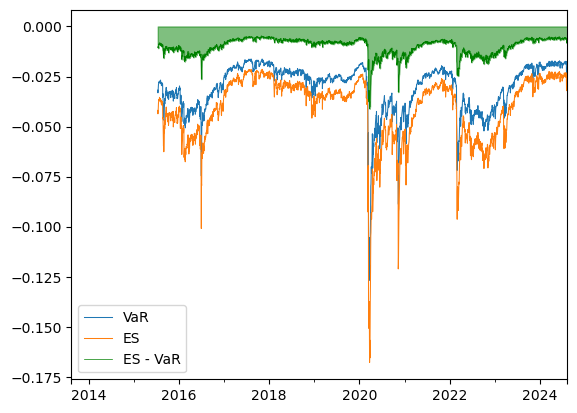

In [157]:
es_norm_mle_v2_x = pd.read_pickle("data/es_norm_mom_v2_margin_t_f0_3.pkl")
var_norm_mle_v2_x = pd.read_pickle("data/var_norm_mom_v2_margin_t_f0_3.pkl")

#mu_pf.plot(label="mu_pf",color="silver",linewidth=0.5)
var_norm_mle_v2_x.plot(label="VaR",linewidth=0.75)
es_norm_mle_v2_x.plot(label="ES",linewidth=0.75)

diff = es_norm_mle_v2_x - var_norm_mle_v2_x
diff.plot(color="green",linewidth=0.5,label="ES - VaR")
plt.fill_between(diff.index,diff.values,color="green",alpha=0.5)

plt.legend()
plt.show()

# t-Copula MoM

## Quantiles

In [10]:
from models.Copulae import tCopulaSimulation

max_ = len(windows_v2)
N_SIMS = 1e5
t_copula = tCopulaSimulation(dispstr="un",method="itau",df=3,df_fixed=True)

start = time.perf_counter()

with ProcessPoolExecutor() as p: #7844 sec margin t f0=3; 9110 sec margin t df=free; 1300 sec margin norm; 1685 sec margin emp.; 4981 sec margin paretor;
    #var_t_mom_v2 = [q for q in tqdm(p.map(partial(func,n=N_SIMS,copula=t_copula,how="parametric",distribution="t",f0=3),windows_v2),total=max_)]
    #var_t_mom_v2 = [q for q in tqdm(p.map(partial(func,n=N_SIMS,copula=t_copula,how="empirical"),windows_v2),total=max_)]
    #var_t_mom_v2 = [q for q in tqdm(p.map(partial(func,n=N_SIMS,copula=t_copula,how="parametric",distribution="pareto"),windows_v2),total=max_)]
    #var_t_mom_v2 = [q for q in tqdm(p.map(partial(func,n=N_SIMS,copula=t_copula,how="parametric",distribution="pareto"),windows_v2),total=max_)]

end = time.perf_counter()

info = f"Calibrations: {max_}\nSimulations (Distribution Fitting): {max_} x {N_SIMS} x 2\nTime [s]: {end-start}"
print(info)

100%|███████████████████████████████████████████████████████████████████████████████| 2622/2622 [48:06<00:00,  1.10s/it]


Calibrations: 2622
Simulations (Distribution Fitting): 2622 x 100000.0 x 2
Time [s]: 4981.644353984


In [17]:
mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)
var_t_mom_v2_s = pd.Series(np.append(pre,var_t_mom_v2),index=index)

#var_t_mom_v2_s.to_pickle("data/var_t_mom_v2_margin_pareto.pkl")

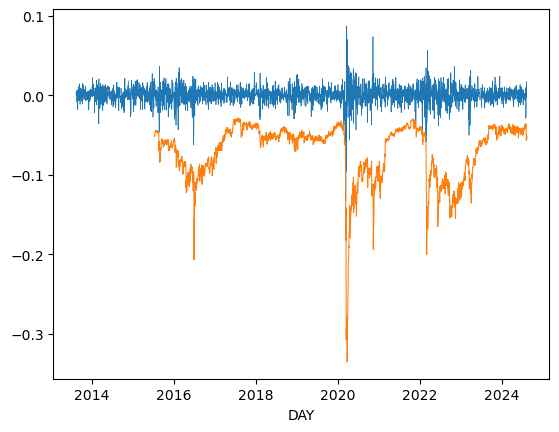

In [15]:
sns.lineplot(mu_pf,linewidth=0.5)
sns.lineplot(var_t_mom_v2_s,linewidth=0.75)

plt.show()

In [16]:
start = var_t_mom_v2_s.index[0]
end = mu_pf.index[-1]

hits = mu_pf[start:end]<var_t_mom_v2_s[start:end]

sum(hits)/len(hits)

0.0010449320794148381

## Expected Shortfall

In [158]:
N_SIMS = 1e5
t_copula = tCopulaSimulation(dispstr="un",method="itau",df=3,df_fixed=True)

with ProcessPoolExecutor() as p:
    #es_t_mom_v2_margin_emp = [es for es in tqdm(p.map(partial(expected_shortfall,how="empirical",n=N_SIMS,copula=t_copula),windows_v2),total=max_)]
    #es_t_mom_v2_margin_norm = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=t_copula,distribution="norm"),windows_v2),total=max_)]
    es_t_mom_v2_margin_t = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=t_copula,distribution="t"),windows_v2),total=max_)]
    #es_t_mom_v2_margin_t_f0_3 = [es for es in tqdm(p.map(partial(expected_shortfall,how="parametric",n=N_SIMS,copula=t_copula,distribution="t",f0=3),windows_v2),total=max_)]


mu_pf = pd.read_pickle("data/mu_pf.pkl")
future = mu_pf.index[-1] + pd.offsets.BusinessDay(1)
index = pd.DatetimeIndex([*mu_pf.index,future])

pre = np.array([np.nan]*250)

#pd.Series(np.append(pre,es_t_mom_v2_margin_emp),index=index).to_pickle("data/es_t_mom_v2_margin_emp.pkl")
#pd.Series(np.append(pre,es_t_mom_v2_margin_norm),index=index).to_pickle("data/es_t_mom_v2_margin_norm.pkl")
pd.Series(np.append(pre,es_t_mom_v2_margin_t),index=index).to_pickle("data/es_t_mom_v2_margin_t.pkl")
#pd.Series(np.append(pre,es_t_mom_v2_margin_t_f0_3),index=index).to_pickle("data/es_t_mom_v2_margin_t_f0_3.pkl")

100%|█████████████████████████████████████████████████████████████████████████████| 2622/2622 [2:29:04<00:00,  3.41s/it]


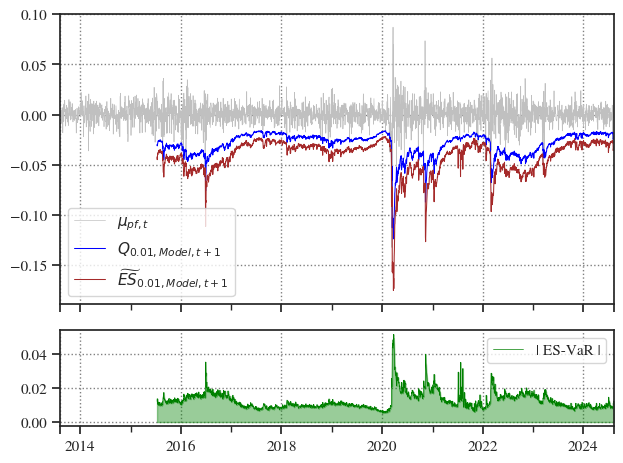

In [137]:
es_t_mle_v2_x = pd.read_pickle("data/es_t_mom_v2_margin_t.pkl")
var_t_mle_v2_x = pd.read_pickle("data/var_t_mom_v2_margin_t.pkl")
mu_pf = pd.read_pickle("data/mu_pf.pkl")

fig, axs = plt.subplots(nrows=2,sharex=True,height_ratios=(3,1))

mu_pf.plot(label=r"$\mu_{pf,t}$",color="silver",linewidth=0.5,ax=axs[0])
var_t_mle_v2_x.plot(label=r"$Q_{0.01,Model,t+1}$",linewidth=0.75,ax=axs[0],color="blue")
es_t_mle_v2_x.plot(label=r"$\widetilde{ES}_{0.01,Model,t+1}$",linewidth=0.75,ax=axs[0],color="brown")
axs[0].legend()

diff = abs(es_t_mle_v2_x - var_t_mle_v2_x)
diff.plot(color="green",linewidth=0.5,label="| ES-VaR |",ax=axs[1])
axs[1].fill_between(diff.index,diff.values,color="green",alpha=0.4)
axs[1].legend()

plt.tight_layout()

#fig.savefig("assets/es_vs_var_t_mom_margin_t.svg")

plt.show()

In [131]:
from backtests.Backtest import simple_hits
hits = simple_hits(mu_pf,es_norm_mle_v2_x)
sum(hits)/len(hits)

0.005063291139240506

# Add. Vizualisations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#sns.set_style(style="ticks",rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})
sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

mu_pf = pd.read_pickle("data/mu_pf.pkl")

In [3]:
var_norm_mle_margin_emp = pd.read_pickle("data/var_norm_mle_v2_margin_emp.pkl")
var_norm_mle_margin_norm = pd.read_pickle("data/var_norm_mle_v2_margin_norm.pkl")
var_norm_mle_margin_t = pd.read_pickle("data/var_norm_mle_v2_margin_t.pkl")
var_norm_mle_margin_t_f0_3 = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")

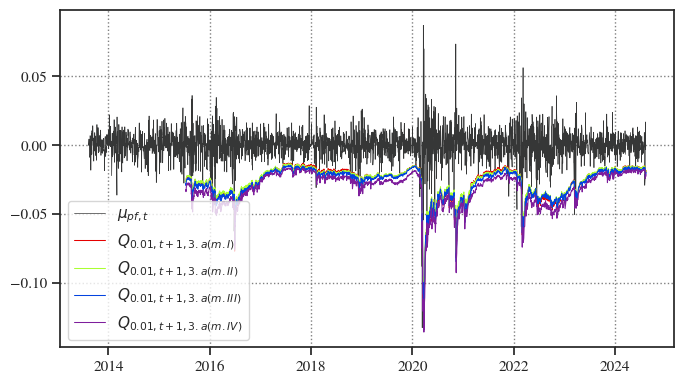

In [17]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(var_norm_mle_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$Q_{0.01,t+1,3.a(m.I)}$")
sns.lineplot(var_norm_mle_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$Q_{0.01,t+1,3.a(m.II)}$")
sns.lineplot(var_norm_mle_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$Q_{0.01,t+1,3.a(m.III)}$")
sns.lineplot(var_norm_mle_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$Q_{0.01,t+1,3.a(m.IV)}$")

plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/var_norm_mle.svg")
plt.show()

In [18]:
es_norm_mle_margin_emp = pd.read_pickle("data/es_norm_mle_v2_margin_emp.pkl")
es_norm_mle_margin_norm = pd.read_pickle("data/es_norm_mle_v2_margin_norm.pkl")
es_norm_mle_margin_t = pd.read_pickle("data/es_norm_mle_v2_margin_t.pkl")
es_norm_mle_margin_t_f0_3 = pd.read_pickle("data/es_norm_mle_v2_margin_t_f0_3.pkl")

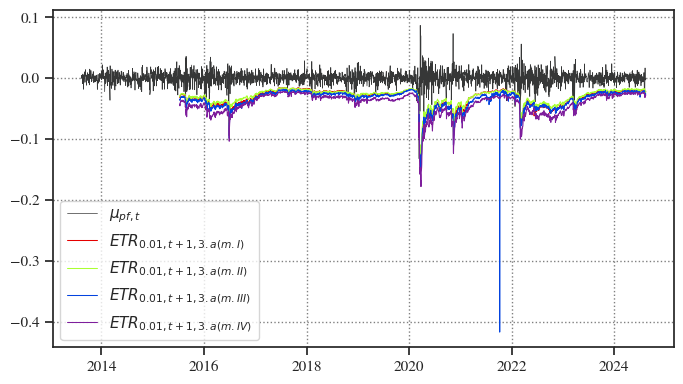

In [21]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(es_norm_mle_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$ETR_{0.01,t+1,3.a(m.I)}$")
sns.lineplot(es_norm_mle_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$ETR_{0.01,t+1,3.a(m.II)}$")
sns.lineplot(es_norm_mle_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$ETR_{0.01,t+1,3.a(m.III)}$")
sns.lineplot(es_norm_mle_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$ETR_{0.01,t+1,3.a(m.IV)}$")

plt.xlabel(None)
plt.tight_layout()
fig.savefig("assets/es_norm_mle.svg")
plt.show()

In [23]:
var_t_mle_margin_emp = pd.read_pickle("data/var_t_mle_v2_margin_emp.pkl")
var_t_mle_margin_norm = pd.read_pickle("data/var_t_mle_v2_margin_norm.pkl")
var_t_mle_margin_t = pd.read_pickle("data/var_t_mle_v2_margin_t.pkl")
var_t_mle_margin_t_f0_3 = pd.read_pickle("data/var_t_mle_v2_margin_t_f0_3.pkl")

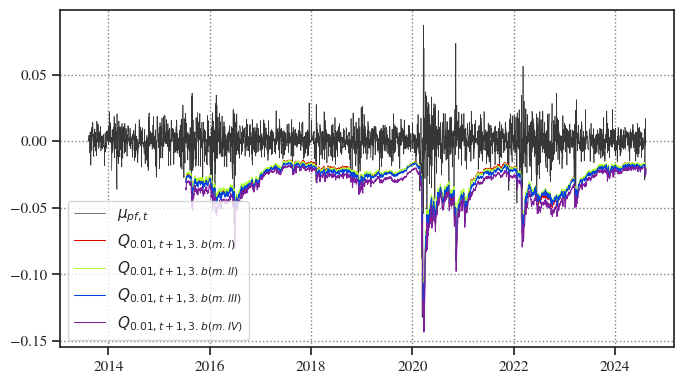

In [30]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(var_t_mle_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$Q_{0.01,t+1,3.b(m.I)}$")
sns.lineplot(var_t_mle_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$Q_{0.01,t+1,3.b(m.II)}$")
sns.lineplot(var_t_mle_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$Q_{0.01,t+1,3.b(m.III)}$")
sns.lineplot(var_t_mle_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$Q_{0.01,t+1,3.b(m.IV)}$")

plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/var_t_mle.svg")
plt.show()

In [31]:
es_t_mle_margin_emp = pd.read_pickle("data/es_t_mle_v2_margin_emp.pkl")
es_t_mle_margin_norm = pd.read_pickle("data/es_t_mle_v2_margin_norm.pkl")
es_t_mle_margin_t = pd.read_pickle("data/es_t_mle_v2_margin_t.pkl")
es_t_mle_margin_t_f0_3 = pd.read_pickle("data/es_t_mle_v2_margin_t_f0_3.pkl")

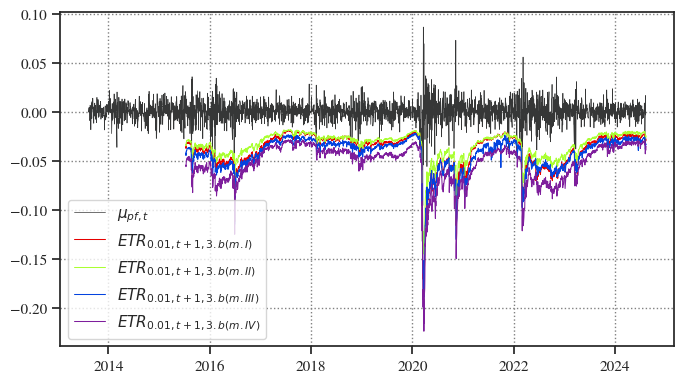

In [34]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(es_t_mle_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$ETR_{0.01,t+1,3.b(m.I)}$")
sns.lineplot(es_t_mle_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$ETR_{0.01,t+1,3.b(m.II)}$")
sns.lineplot(es_t_mle_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$ETR_{0.01,t+1,3.b(m.III)}$")
sns.lineplot(es_t_mle_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$ETR_{0.01,t+1,3.b(m.IV)}$")

plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/es_t_mle.svg")
plt.show()

In [35]:
var_norm_mom_margin_emp = pd.read_pickle("data/var_norm_mom_v2_margin_emp.pkl")
var_norm_mom_margin_norm = pd.read_pickle("data/var_norm_mom_v2_margin_norm.pkl")
var_norm_mom_margin_t = pd.read_pickle("data/var_norm_mom_v2_margin_t.pkl")
var_norm_mom_margin_t_f0_3 = pd.read_pickle("data/var_norm_mom_v2_margin_t_f0_3.pkl")

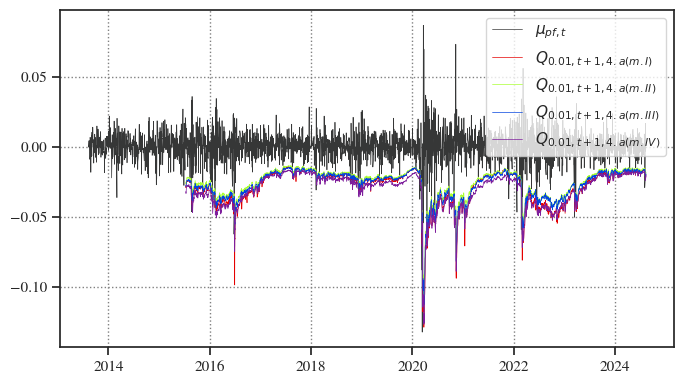

In [44]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(var_norm_mom_margin_emp,linewidth=0.5,color="xkcd:red",label=r"$Q_{0.01,t+1,4.a(m.I)}$")
sns.lineplot(var_norm_mom_margin_norm,linewidth=0.5,color="xkcd:lime",label=r"$Q_{0.01,t+1,4.a(m.II)}$")
sns.lineplot(var_norm_mom_margin_t,linewidth=0.5,color="xkcd:blue",label=r"$Q_{0.01,t+1,4.a(m.III)}$")
sns.lineplot(var_norm_mom_margin_t_f0_3,linewidth=0.5,color="xkcd:purple",label=r"$Q_{0.01,t+1,4.a(m.IV)}$")
sns.move_legend(ax,"upper right")
plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/var_norm_mom.svg")
plt.show()

In [45]:
es_norm_mom_margin_emp = pd.read_pickle("data/es_norm_mom_v2_margin_emp.pkl")
es_norm_mom_margin_norm = pd.read_pickle("data/es_norm_mom_v2_margin_norm.pkl")
es_norm_mom_margin_t = pd.read_pickle("data/es_norm_mom_v2_margin_t.pkl")
es_norm_mom_margin_t_f0_3 = pd.read_pickle("data/es_norm_mom_v2_margin_t_f0_3.pkl")

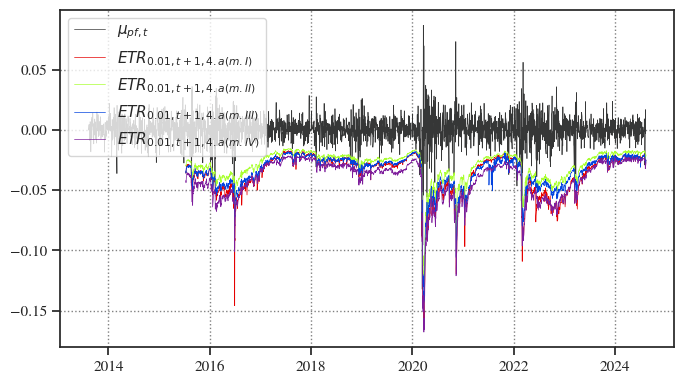

In [53]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(es_norm_mom_margin_emp,linewidth=0.5,color="xkcd:red",label=r"$ETR_{0.01,t+1,4.a(m.I)}$")
sns.lineplot(es_norm_mom_margin_norm,linewidth=0.5,color="xkcd:lime",label=r"$ETR_{0.01,t+1,4.a(m.II)}$")
sns.lineplot(es_norm_mom_margin_t,linewidth=0.5,color="xkcd:blue",label=r"$ETR_{0.01,t+1,4.a(m.III)}$")
sns.lineplot(es_norm_mom_margin_t_f0_3,linewidth=0.5,color="xkcd:purple",label=r"$ETR_{0.01,t+1,4.a(m.IV)}$")
sns.move_legend(ax,"upper left")
plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/es_norm_mom.svg")
plt.show()

In [55]:
var_t_mom_margin_emp = pd.read_pickle("data/var_t_mom_v2_margin_emp.pkl")
var_t_mom_margin_norm = pd.read_pickle("data/var_t_mom_v2_margin_norm.pkl")
var_t_mom_margin_t = pd.read_pickle("data/var_t_mom_v2_margin_t.pkl")
var_t_mom_margin_t_f0_3 = pd.read_pickle("data/var_t_mom_v2_margin_t_f0_3.pkl")

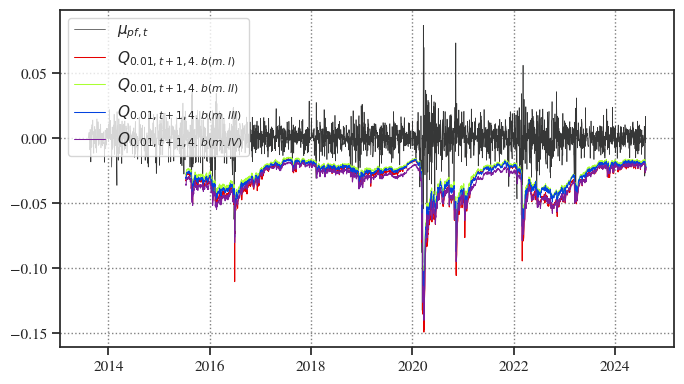

In [60]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(var_t_mom_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$Q_{0.01,t+1,4.b(m.I)}$")
sns.lineplot(var_t_mom_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$Q_{0.01,t+1,4.b(m.II)}$")
sns.lineplot(var_t_mom_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$Q_{0.01,t+1,4.b(m.III)}$")
sns.lineplot(var_t_mom_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$Q_{0.01,t+1,4.b(m.IV)}$")
sns.move_legend(ax,"upper left")
plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/var_t_mom.svg")
plt.show()

In [61]:
es_t_mom_margin_emp = pd.read_pickle("data/es_t_mom_v2_margin_emp.pkl")
es_t_mom_margin_norm = pd.read_pickle("data/es_t_mom_v2_margin_norm.pkl")
es_t_mom_margin_t = pd.read_pickle("data/es_t_mom_v2_margin_t.pkl")
es_t_mom_margin_t_f0_3 = pd.read_pickle("data/es_t_mom_v2_margin_t_f0_3.pkl")

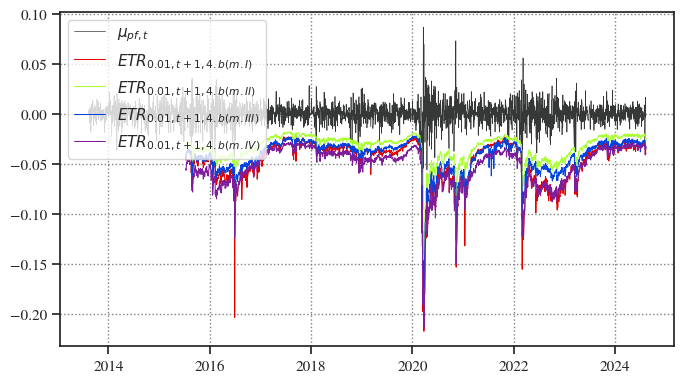

In [67]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(mu_pf,linewidth=0.5,color="xkcd:dark grey",label=r"$\mu_{pf,t}$")
sns.lineplot(es_t_mom_margin_emp,linewidth=0.75,color="xkcd:red",label=r"$ETR_{0.01,t+1,4.b(m.I)}$")
sns.lineplot(es_t_mom_margin_norm,linewidth=0.75,color="xkcd:lime",label=r"$ETR_{0.01,t+1,4.b(m.II)}$")
sns.lineplot(es_t_mom_margin_t,linewidth=0.75,color="xkcd:blue",label=r"$ETR_{0.01,t+1,4.b(m.III)}$")
sns.lineplot(es_t_mom_margin_t_f0_3,linewidth=0.75,color="xkcd:purple",label=r"$ETR_{0.01,t+1,4.b(m.IV)}$")
sns.move_legend(ax,"upper left")
plt.xlabel(None)
plt.tight_layout()
#fig.savefig("assets/es_t_mom.svg")
plt.show()

# Backtests

In [29]:
from backtests.Backtest import simple_hits, kupiec_test, christofferson_test, VaRTest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#sns.set_style(style="ticks",rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})
sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

mu_pf = pd.read_pickle("data/mu_pf.pkl")

In [30]:
def evaluate_hits(actual:pd.Series,var:pd.Series,plot_actual=True,show_n=True,ax=None,model:str=None,color:tuple[str,str]=("blue","red")):
    hits = simple_hits(actual,var)

    n = sum(hits)
    
    points = var.loc[hits[hits==True].index]
    
    if plot_actual:
        sns.lineplot(actual[hits.index],color="xkcd:silver",ax=ax,linewidth=0.5,label=r"$r_{pf,t}$")

    lbl = f"$Q_{{0.01,{model},t+1}}$" if model else "$Q_{0.01,t+1}$"
    
    sns.lineplot(var[hits.index],color=color[0],ax=ax,linewidth=0.5,label=r"".join(lbl))

    obj = ax if ax else plt
    n_lbl = f"{n} hits" if show_n else None
    obj.plot(points,linewidth=0,marker="x",color=color[1],label=n_lbl)

    plt.xlabel(None)
    obj.legend()
    
    #plt.show()

    return n/len(hits)

## Variance Covariance

0.019831223628691982

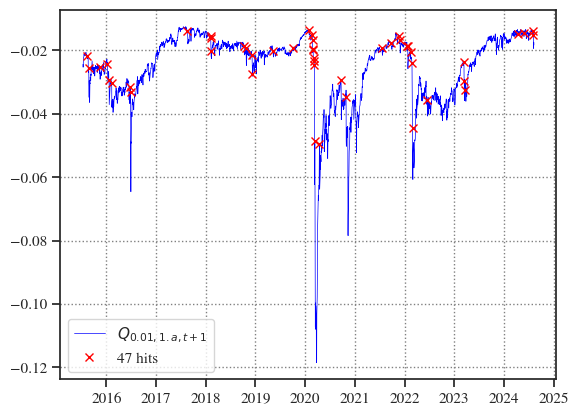

In [31]:


mu_pf = pd.read_pickle("data/mu_pf.pkl")
var_cov = pd.read_pickle("data/var_cov_v2.pkl")

evaluate_hits(mu_pf,var_cov,plot_actual=False,model="1.a")

In [32]:
VaRTest(0.01,mu_pf,var_cov,0.95)

expected.exceed                                 23.0
actual.exceed                                   47.0
uc.H0                            Correct Exceedances
uc.LRstat                                  17.991371
uc.critical                                 3.841459
uc.LRp                                      0.000022
uc.Decision                                Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  40.556968
cc.critical                                 5.991465
cc.LRp                                           0.0
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [33]:
hits = simple_hits(mu_pf,var_cov)
kupiec_test(0.01,hits,conf_level=0.95)

uc.H0          Correct Exceedances
uc.LRstat                17.991371
uc.critical               3.841459
uc.LRp                    0.000022
uc.Decision              Reject H0
dtype: object

In [34]:
christofferson_test(hits,conf_level=0.95)

ind.H0          Independent
ind.LRstat        22.565597
ind.critical       3.841459
ind.LRp            0.000002
ind.Decision      Reject H0
dtype: object

## Historical Simulation

0.014345991561181435

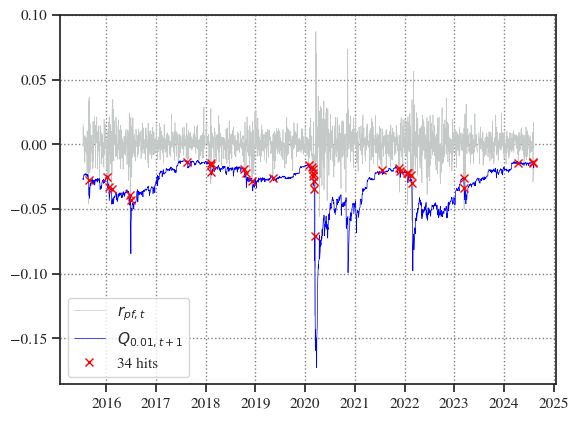

In [35]:
var_hist = pd.read_pickle("data/var_hist_v2.pkl")
hits = simple_hits(mu_pf,var_hist)

evaluate_hits(mu_pf,var_hist)

In [36]:
VaRTest(0.01,mu_pf,var_hist,0.95)

expected.exceed                                 23.0
actual.exceed                                   34.0
uc.H0                            Correct Exceedances
uc.LRstat                                   3.985495
uc.critical                                 3.841459
uc.LRp                                      0.045894
uc.Decision                                Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  30.980433
cc.critical                                 5.991465
cc.LRp                                           0.0
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [37]:
christofferson_test(hits,conf_level=0.99)

ind.H0          Independent
ind.LRstat        26.994938
ind.critical       6.634897
ind.LRp                 0.0
ind.Decision      Reject H0
dtype: object

## Meta-Gaussian MLE

In [38]:
var_norm_mle_margin_emp = pd.read_pickle("data/var_norm_mle_v2_margin_emp.pkl")
var_norm_mle_margin_norm = pd.read_pickle("data/var_norm_mle_v2_margin_norm.pkl")
var_norm_mle_margin_t = pd.read_pickle("data/var_norm_mle_v2_margin_t.pkl")
var_norm_mle_margin_t_f0_3 = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")

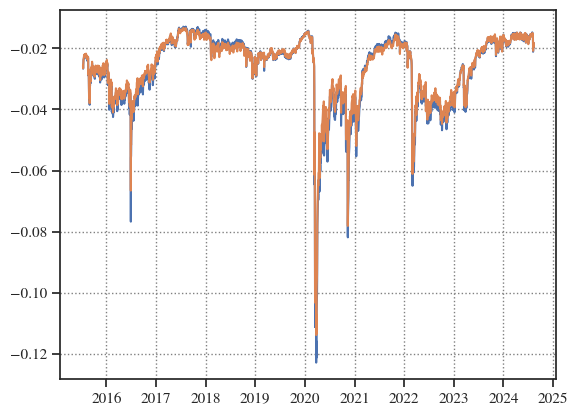

(42, 42)

In [39]:
#Test
sns.lineplot(var_norm_mle_margin_emp)
sns.lineplot(var_norm_mle_margin_norm)
plt.show()
sum(simple_hits(mu_pf,var_norm_mle_margin_emp)),sum( simple_hits(mu_pf,var_norm_mle_margin_norm))

True

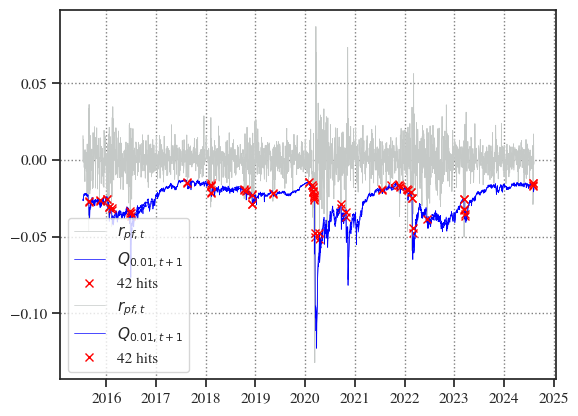

In [40]:
evaluate_hits(mu_pf,var_norm_mle_margin_emp) == evaluate_hits(mu_pf,var_norm_mle_margin_norm)

In [44]:
hits = simple_hits(mu_pf,var_norm_mle_margin_t_f0_3)
sum(hits)/len(hits)

0.009704641350210971

In [41]:
VaRTest(0.01,mu_pf,var_norm_mle_margin_t_f0_3,conf_level=0.99)

expected.exceed                                 23.0
actual.exceed                                   23.0
uc.H0                            Correct Exceedances
uc.LRstat                                   0.021091
uc.critical                                 6.634897
uc.LRp                                      0.884533
uc.Decision                        Fail to Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  10.764427
cc.critical                                  9.21034
cc.LRp                                      0.004598
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [29]:
hits = simple_hits(mu_pf,var_norm_mle_margin_emp)
christofferson_test(hits,conf_level=0.95)

ind.H0          Independent
ind.LRstat        26.217715
ind.critical       3.841459
ind.LRp                 0.0
ind.Decision      Reject H0
dtype: object

## Meta-Student t MLE

In [11]:
var_t_mle_margin_emp = pd.read_pickle("data/var_t_mle_v2_margin_emp.pkl")
var_t_mle_margin_norm = pd.read_pickle("data/var_t_mle_v2_margin_norm.pkl")
var_t_mle_margin_t = pd.read_pickle("data/var_t_mle_v2_margin_t.pkl")
var_t_mle_margin_t_f0_3 = pd.read_pickle("data/var_t_mle_v2_margin_t_f0_3.pkl")

0.007172995780590718

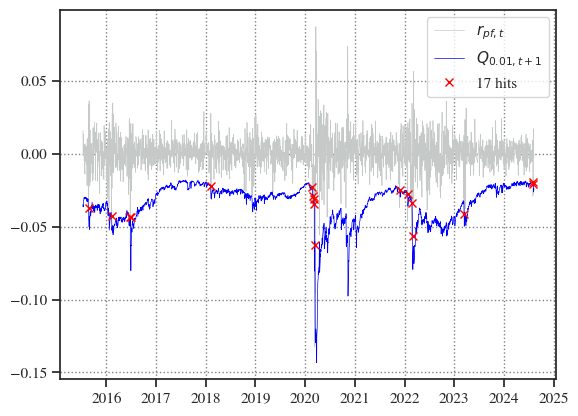

In [12]:
evaluate_hits(mu_pf,var_t_mle_margin_t_f0_3)

In [18]:
VaRTest(0.01,mu_pf,var_t_mle_margin_t,0.95)

expected.exceed                                 23.0
actual.exceed                                   33.0
uc.H0                            Correct Exceedances
uc.LRstat                                   3.285057
uc.critical                                 3.841459
uc.LRp                                      0.069913
uc.Decision                        Fail to Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  25.049181
cc.critical                                 5.991465
cc.LRp                                      0.000004
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [38]:
hits = simple_hits(mu_pf,var_t_mle_margin_t_f0_3)
christofferson_test(hits,conf_level=0.99)

ind.H0          Independent
ind.LRstat        14.504583
ind.critical       6.634897
ind.LRp             0.00014
ind.Decision      Reject H0
dtype: object

## Meta-Gaussian MoM

In [60]:
var_norm_mom_margin_emp = pd.read_pickle("data/var_norm_mom_v2_margin_emp.pkl")
var_norm_mom_margin_norm = pd.read_pickle("data/var_norm_mom_v2_margin_norm.pkl")
var_norm_mom_margin_t = pd.read_pickle("data/var_norm_mom_v2_margin_t.pkl")
var_norm_mom_margin_t_f0_3 = pd.read_pickle("data/var_norm_mom_v2_margin_t_f0_3.pkl")

0.010970464135021098

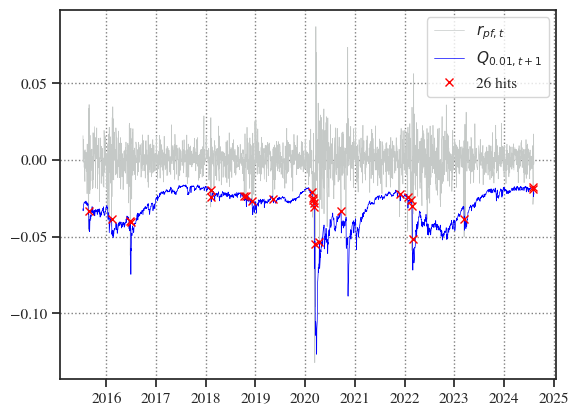

In [61]:
evaluate_hits(mu_pf,var_norm_mom_margin_t_f0_3)

In [65]:
VaRTest(0.01,mu_pf,var_norm_mom_margin_t_f0_3,conf_level=0.99)

expected.exceed                                 23.0
actual.exceed                                   26.0
uc.H0                            Correct Exceedances
uc.LRstat                                   0.218573
uc.critical                                 6.634897
uc.LRp                                       0.64013
uc.Decision                        Fail to Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  15.046803
cc.critical                                  9.21034
cc.LRp                                       0.00054
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [24]:
hits = simple_hits(mu_pf,var_norm_mom_margin_t_f0_3)
christofferson_test(hits,conf_level=0.99)

ind.H0          Independent
ind.LRstat         14.82823
ind.critical       6.634897
ind.LRp            0.000118
ind.Decision      Reject H0
dtype: object

## Meta Student-t MoM

In [66]:
var_t_mom_margin_emp = pd.read_pickle("data/var_t_mom_v2_margin_emp.pkl")
var_t_mom_margin_norm = pd.read_pickle("data/var_t_mom_v2_margin_norm.pkl")
var_t_mom_margin_t = pd.read_pickle("data/var_t_mom_v2_margin_t.pkl")
var_t_mom_margin_t_f0_3 = pd.read_pickle("data/var_t_mom_v2_margin_t_f0_3.pkl")

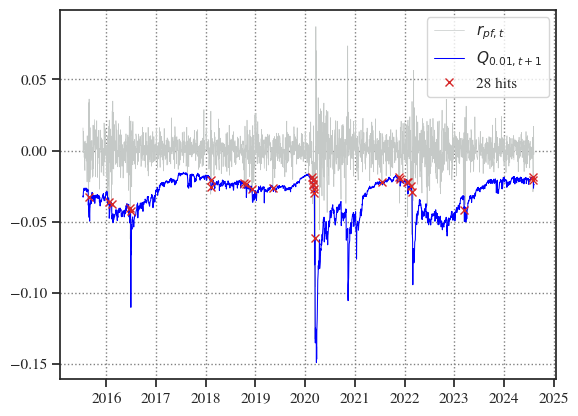

0.01181434599156118

In [26]:
evaluate_hits(mu_pf,var_t_mom_margin_emp)

In [70]:
VaRTest(0.01,mu_pf,var_t_mom_margin_t_f0_3,conf_level=0.99)

expected.exceed                                 23.0
actual.exceed                                   18.0
uc.H0                            Correct Exceedances
uc.LRstat                                   1.510118
uc.critical                                 6.634897
uc.LRp                                      0.219121
uc.Decision                        Fail to Reject H0
cc.H0              Correct Exceedances & Independent
cc.LRstat                                  15.286985
cc.critical                                  9.21034
cc.LRp                                      0.000479
cc.Decision                                Reject H0
n                                               2370
dtype: object

In [36]:
hits = simple_hits(mu_pf,var_t_mom_margin_t_f0_3)
christofferson_test(hits,conf_level=0.99)

ind.H0          Independent
ind.LRstat        13.776867
ind.critical       6.634897
ind.LRp            0.000206
ind.Decision      Reject H0
dtype: object

# Additional Plots

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 

from data.data import df_tr, df_tr_log, df_tr_log_red

sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

In [69]:
df_tr.loc[:,"O:BWGP"].dropna()
sub_date = df_tr.loc[:,"O:BWGP"].dropna().index[0]

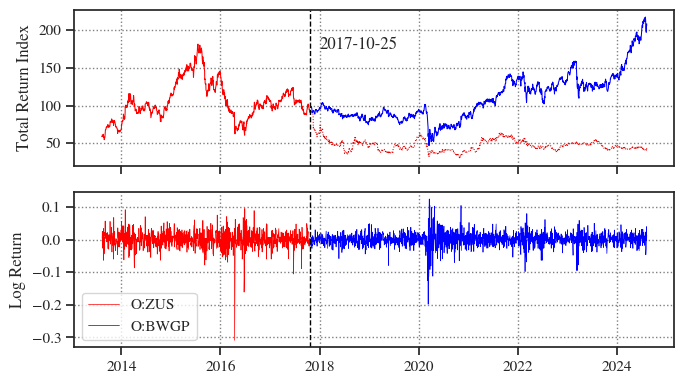

In [81]:
an_date = sub_date + pd.offsets.BDay(50)

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(7,4))

sns.lineplot(df_tr.loc[:sub_date,"O:ZUS"],color="red",linewidth=0.75,ax=axs[0])
sns.lineplot(df_tr.loc[sub_date:,"O:ZUS"],color="xkcd:red",linestyle="dotted",linewidth=0.75,ax=axs[0])

sns.lineplot(df_tr.loc[:,"O:BWGP"],color="blue",linewidth=0.75,ax=axs[0])

axs[0].axvline(sub_date,color="black",linewidth=1,linestyle="--")

axs[0].set_ylabel("Total Return Index")
axs[0].annotate(sub_date.strftime("%Y-%m-%d"),(sub_date,175),xytext=(an_date,175))


sns.lineplot(df_tr_log.loc[:sub_date,"O:ZUS"],ax = axs[1],color="red",linewidth=0.5,label="O:ZUS")
sns.lineplot(df_tr_log.loc[:,"O:BWGP"],ax = axs[1],color="blue",linewidth=0.5,label="O:BWGP")

axs[1].axvline(sub_date,color="black",linewidth=1,linestyle="--")

axs[1].set_ylabel("Log Return")
axs[1].set_xlabel(None)

plt.tight_layout()

#fig.savefig("assets/bwgp_zus.svg")

plt.show()

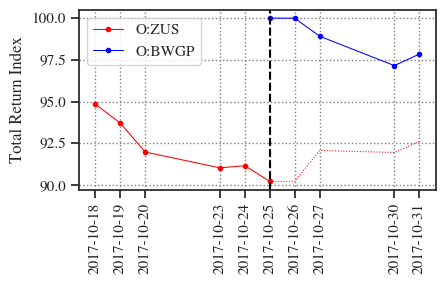

In [195]:
start_detail = sub_date + pd.offsets.BDay(n=-5)
end_detail = sub_date + pd.offsets.BDay(n=4)

fig, ax = plt.subplots(figsize=(4.5,3))

ax.plot(df_tr.loc[start_detail:sub_date,"O:ZUS"],linewidth=0.75,color="red",marker=".",label="O:ZUS")
ax.plot(df_tr.loc[sub_date:end_detail,"O:ZUS"],linewidth=0.75,color="red",linestyle="dotted")
ax.plot(df_tr.loc[start_detail:end_detail,"O:BWGP"],linewidth=0.75,color="blue",marker=".",label="O:BWGP")
ax.axvline(x=sub_date,color="black",linestyle="dashed")
#ax.annotate("  "+sub_date.strftime("%Y-%m-%d"),(sub_date,96))
plt.xlabel(None)
plt.ylabel("Total Return Index")
plt.legend()
plt.xticks(df_tr.loc[start_detail:end_detail,:].index,rotation=90)
plt.tight_layout()

#fig.savefig("assets/bwgp_zus_index_detail.svg")

plt.show()

In [159]:
df_tr.loc[sub_date,"O:ZUS"]

90.23

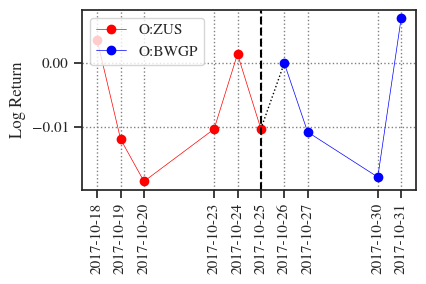

In [197]:
fig, ax = plt.subplots(figsize=(4.5,3))
next_day = sub_date + pd.offsets.BDay(1)
def get_xy(ticker):
    return df_tr_log.loc[start_detail:end_detail,ticker].index,df_tr_log.loc[start_detail:end_detail,ticker].values

#plt.vlines(get_xy("O:ZUS")[0],0,get_xy("O:ZUS")[1],color="red",linewidth=0.5)
ax.plot(df_tr_log.loc[start_detail:sub_date,"O:ZUS"],linewidth=0.5,linestyle="solid",marker="o",color="red",label="O:ZUS")

#plt.vlines(get_xy("O:BWGP")[0],0,get_xy("O:BWGP")[1],color="blue",linewidth=0.5)
ax.plot(df_tr_log.loc[start_detail:end_detail,"O:BWGP"],linewidth=0.5,linestyle="solid",color="blue",marker="o",label="O:BWGP")

ax.plot(df_tr_log_red.loc[sub_date:next_day,"O:BWGPZUS"],color="black",linewidth=1,linestyle="dotted")

ax.axvline(x=sub_date,color="black",linestyle="dashed")
#ax.annotate("  "+sub_date.strftime("%Y-%m-%d"),(sub_date,0.005))

plt.xticks(df_tr_log_red.loc[start_detail:end_detail,:].index,rotation=90)

plt.legend()
sns.move_legend(ax,"upper left")
plt.ylabel("Log Return")

plt.tight_layout()
#fig.savefig("assets/bwgp_zus_return_detail.svg")

plt.show()

In [86]:
df_info = df_tr_log_red.describe(percentiles=[0.1,0.9])

In [99]:
df_info.loc["skew",:] = df_tr_log_red.skew()
df_info.loc["kurt",:] = df_tr_log_red.kurtosis()

In [100]:
df_info.rename({"50%":"median"},inplace=True)
df_info

O:AND        O:ATS  ...       O:WNBA    O:BWGPZUS
count   2870.000000  2870.000000  ...  2870.000000  2870.000000
mean       0.000232     0.000325  ...     0.000426     0.000406
std        0.016791     0.025681  ...     0.020217     0.022739
min       -0.116668    -0.174281  ...    -0.179808    -0.309286
10%       -0.018774    -0.028638  ...    -0.020492    -0.023426
median     0.000000     0.000000  ...     0.000000     0.000000
90%        0.018105     0.029229  ...     0.021435     0.024982
max        0.103647     0.193867  ...     0.154028     0.125367
skew      -0.100143     0.089447  ...    -0.701072    -1.327060
kurt       4.643803     4.767956  ...     9.743171    17.489015

[10 rows x 20 columns]

In [104]:
df_info = df_info.reindex(["count","mean","median","std","skew","kurt","10%","90%","min","max"])

In [107]:
#df_info.to_excel("assets/descr_stats.xlsx")

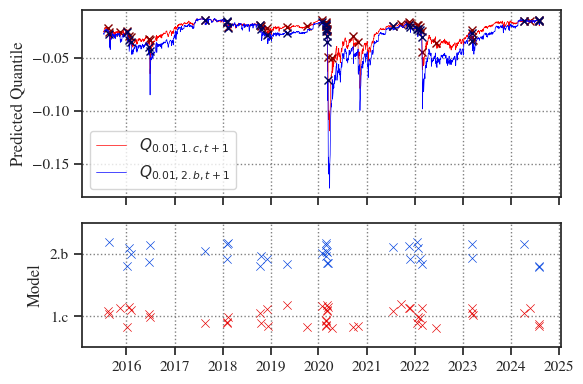

In [205]:
import random

var_cov = pd.read_pickle("data/var_cov_v2.pkl")
var_hist = pd.read_pickle("data/var_hist_v2.pkl")
mu_pf = pd.read_pickle("data/mu_pf.pkl")


fig, axs = plt.subplots(nrows=2,sharex=True,height_ratios=(3,2),figsize=(6,4))

evaluate_hits(mu_pf,var_cov,ax=axs[0],plot_actual=False,color=("red","xkcd:dark red"),model="1.c",show_n=False)
evaluate_hits(mu_pf,var_hist,ax=axs[0],plot_actual=False,color=("blue","xkcd:dark blue"),model="2.b",show_n=False)
#axs[0].legend().remove()
axs[0].set_ylabel("Predicted Quantile")

def evaluate_hit_clusters(actual,var,ax=None,mult:int=1,label=None,color=None):
    hits = simple_hits(actual,var)
    hits = hits[hits==True]*mult
    spread = 0.2
    hits = hits.apply(lambda x: x+random.uniform(-spread,spread))
    sns.scatterplot(hits,ax=ax,marker="x",color=color,label=f"{len(hits)} hits",sizes=2)
    if ax:
        ax.set_xlabel(None)
    else:
        plt.set_xlabel(None)

                         

evaluate_hit_clusters(mu_pf,var_cov,ax=axs[1],color="xkcd:red")
evaluate_hit_clusters(mu_pf,var_hist,ax=axs[1],mult=2,color="xkcd:blue")

axs[1].set_yticks([1,2])
axs[1].set_yticklabels(["1.c","2.b"])
axs[1].set_ylim(0.5,2.5)
axs[1].legend().remove()
axs[1].set_ylabel("Model")

plt.tight_layout()

#fig.savefig("assets/hits_cov_hist.svg")

plt.show()

In [206]:
var_cov = pd.read_pickle("data/var_cov_v2.pkl")
es_cov = pd.read_pickle("data/es_cov_v2.pkl")

var_hist = pd.read_pickle("data/var_hist_v2.pkl")
es_hist = pd.read_pickle("data/es_hist_v2.pkl")
mu_pf = pd.read_pickle("data/mu_pf.pkl")

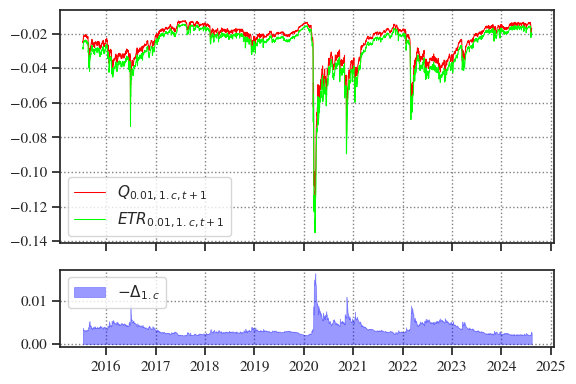

In [357]:
def evaluate_var_es(var,es,axs,model="",colors=["red","blue","green"]):
    diff = -1* (es - var)
    index = f"0.01,{model},t+1"
    
    axs[0].plot(var,linewidth=0.75,label=rf"$Q_{{{index}}}$",color=colors[0])
    axs[0].plot(es,linewidth=0.75,label=rf"$ETR_{{{index}}}$",color=colors[1])
    axs[0].legend()

    axs[1].fill_between(diff.index,diff,color=colors[2],alpha=0.4,label=rf"$-\Delta_{{{model}}}$",linewidth=0.5)
    axs[1].legend()
    sns.move_legend(axs[1],"upper left")

    plt.tight_layout()

fig, axs = plt.subplots(nrows=2,sharex=True,height_ratios=(3,1),figsize=(6,4))

evaluate_var_es(var_cov,es_cov,axs,model="1.c",colors=["red","lime","blue"])

#fig.savefig("assets/diff_cov.svg")

plt.show()

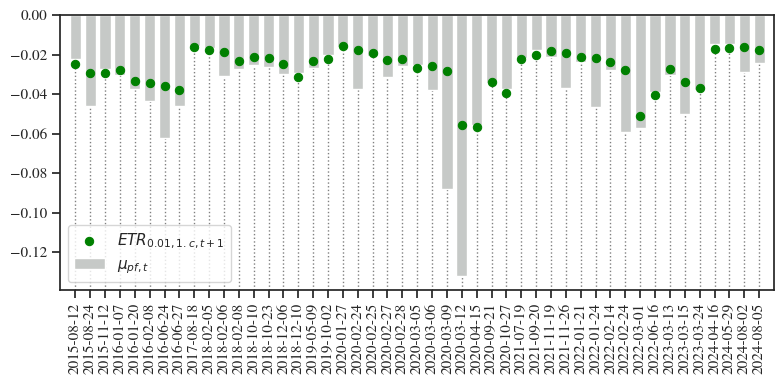

In [856]:
fig, ax = plt.subplots(figsize=(8,4))

hits = simple_hits(mu_pf,var_cov)
dates = hits.loc[hits==True].index

sns.barplot(mu_pf.loc[dates],color="xkcd:silver",label=r"$\mu_{pf,t}$",width=0.75,fill=True,edgecolor=None)

style = {"marker":"o","linewidth":0.75}
#ax.scatter(range(len(dates)),var_norm_mle_margin_emp.loc[dates.values],color="xkcd:dark grey",label=r"$Q_{0.01,3.a(m.I),t+1}$",**style)
ax.scatter(range(len(dates)),es_cov.loc[dates].values,color="green",label=r"$ETR_{0.01,1.c,t+1}$",**style)

ax.grid(axis="y")
ax.grid(axis="x")
ax.set_xlim(left=-1,right=len(dates))
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
#fig.savefig("assets/es_vs_mu_1c.svg")

plt.show()

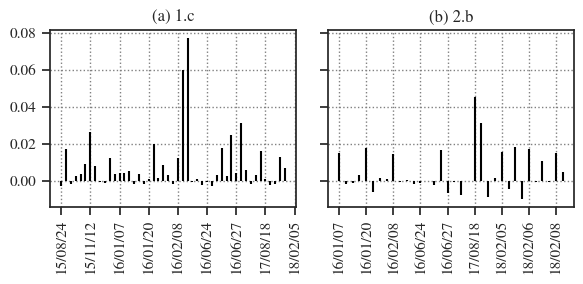

In [1041]:
#Unscaled one-sided bootstrap test as alternative to a t-test
# McNeil & Frey, 2000
# bootstrap residual means and count the number of simulations that are > 0 divided by the number of samples

def residuals(mu_pf,var,es):
    hits = simple_hits(mu_pf,var)
    hit_days = hits.loc[hits==True].index
    return es.loc[hit_days] - mu_pf.loc[hit_days]

def plot_residuals(mu_pf,var,es,ax,color="black",n_labels=10):
    res = residuals(mu_pf,var,es)
    ax.vlines(range(len(res)),0,res.values,color=color)
    ax.set_xticklabels(res.index.strftime("%y/%m/%d"))
    ax.tick_params(axis='x' ,labelrotation=90)
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels))


fig, axs = plt.subplots(ncols=2,sharey=True,figsize=(6,3))

plot_residuals(mu_pf,var_cov,es_cov,axs[0])
axs[0].set_title("(a) 1.c")
plot_residuals(mu_pf,var_hist,es_hist,axs[1])
axs[1].set_title("(b) 2.b")

plt.tight_layout()

#fig.savefig("assets/residuals_1c_2b.svg")

plt.show()

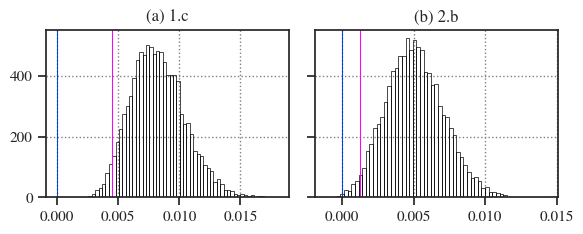

In [1126]:
def plot_es_test(mu_pf,var,es,ax,ci=0.99):
    obs = residuals(mu_pf,var,es)

    statistic = lambda a: np.mean(a)
    result = bootstrap((obs,),statistic,confidence_level=ci,alternative="greater")
    lower = result.confidence_interval.low
    higher = result.confidence_interval.high
    sim = result.bootstrap_distribution
    sns.histplot(sim,kde=False,fill=False,color="black",ax=ax)
    ax.axvline(lower,color="magenta",linewidth=0.75)
    ax.axvline(higher,color="magenta",linewidth=0.75)
    ax.axvline(0,color="xkcd:blue",linewidth=0.75)
    ax.set_ylabel(None)

fig, axs = plt.subplots(ncols=2,figsize=(6,2.5),sharey=True)

ci = 0.99

plot_es_test(mu_pf,var_cov,es_cov,axs[0],ci=ci)
plot_es_test(mu_pf,var_hist,es_hist,axs[1],ci=ci)

axs[0].set_title("(a) 1.c")
axs[1].set_title("(b) 2.b")

plt.tight_layout()

#fig.savefig("assets/es_test_1c_2b.svg")
plt.show()

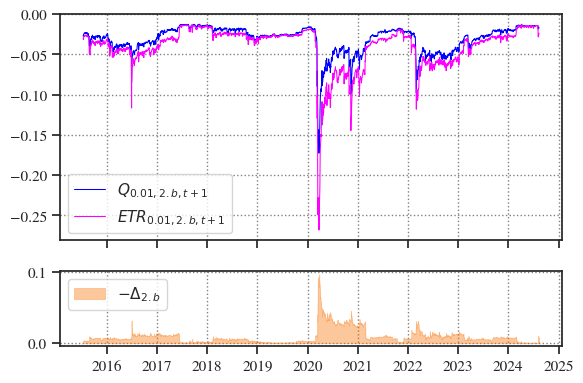

In [358]:
fig, axs = plt.subplots(nrows=2,sharex=True,height_ratios=(3,1),figsize=(6,4))

evaluate_var_es(var_hist,es_hist,axs,model="2.b",colors=["blue","magenta","xkcd:orange"])

#fig.savefig("assets/diff_hist.svg")

plt.show()

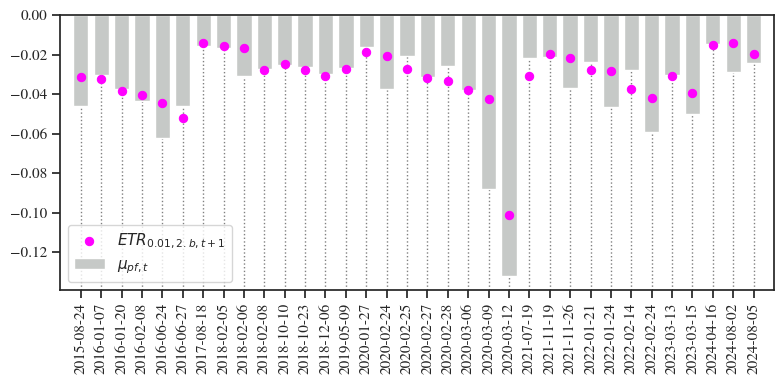

In [857]:
fig, ax = plt.subplots(figsize=(8,4))

hits = simple_hits(mu_pf,var_hist)
dates = hits.loc[hits==True].index

sns.barplot(mu_pf.loc[dates],color="xkcd:silver",label=r"$\mu_{pf,t}$",width=0.75,fill=True,edgecolor=None)

style = {"marker":"o","linewidth":0.75}
#ax.scatter(range(len(dates)),var_norm_mle_margin_emp.loc[dates.values],color="xkcd:dark grey",label=r"$Q_{0.01,3.a(m.I),t+1}$",**style)
ax.scatter(range(len(dates)),es_hist.loc[dates].values,color="magenta",label=r"$ETR_{0.01,2.b,t+1}$",**style)

ax.grid(axis="y")
ax.grid(axis="x")
ax.set_xlim(left=-1,right=len(dates))
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
#fig.savefig("assets/es_vs_mu_2b.svg")

plt.show()

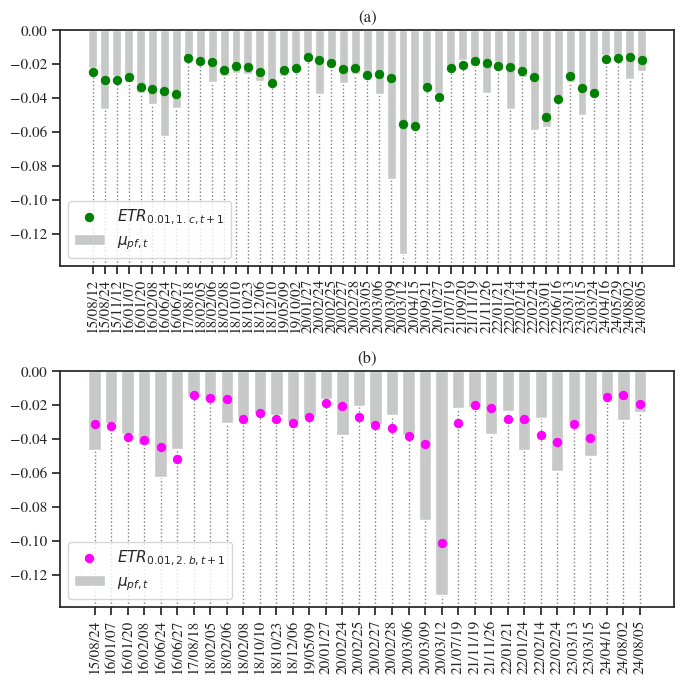

In [870]:
fig, axs = plt.subplots(nrows=2,figsize=(7,7))

style = {"marker":"o","linewidth":0.75}

#cov
hits = simple_hits(mu_pf,var_cov)
dates = hits.loc[hits==True].index
sns.barplot(mu_pf.loc[dates],color="xkcd:silver",label=r"$\mu_{pf,t}$",width=0.75,fill=True,edgecolor=None,ax=axs[0])

axs[0].scatter(range(len(dates)),es_cov.loc[dates].values,color="green",label=r"$ETR_{0.01,1.c,t+1}$",**style)
axs[0].set_xticklabels(dates.strftime("%y/%m/%d"))
axs[0].set_title("(a)")

#hist
hits = simple_hits(mu_pf,var_hist)
dates = hits.loc[hits==True].index

sns.barplot(mu_pf.loc[dates],color="xkcd:silver",label=r"$\mu_{pf,t}$",width=0.75,fill=True,edgecolor=None,ax=axs[1])
axs[1].scatter(range(len(dates)),es_hist.loc[dates].values,color="magenta",label=r"$ETR_{0.01,2.b,t+1}$",**style)
axs[1].set_xticklabels(dates.strftime("%y/%m/%d"))
axs[1].set_title("(b)")

for ax in axs:
    ax.grid(axis="y")
    ax.grid(axis="x")
    ax.tick_params(axis="x",rotation=90)
    ax.legend()
    
plt.tight_layout()
#fig.savefig("assets/es_vs_mu_1c_2b.svg")

plt.show()

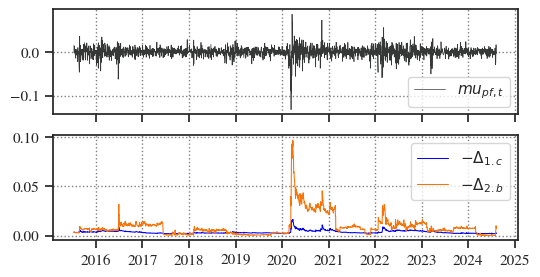

In [672]:
fig, axs = plt.subplots(figsize=(6,3),nrows=2,sharex=True)

start_date = es_cov.dropna().index[0]
sns.lineplot(mu_pf.loc[start_date:],ax=axs[0],linewidth=0.5,color="xkcd:dark grey",label=r"$mu_{pf,t}$")

sns.lineplot(-(es_cov - var_cov),color="blue",linewidth=0.75,label=r"$-\Delta_{1.c}$",ax=axs[1])
sns.lineplot(-(es_hist - var_hist),color="xkcd:orange",linewidth=0.75,label=r"$-\Delta_{2.b}$",ax=axs[1])

#fig.savefig("assets/diff_cov_vs_hist.svg")

plt.show()

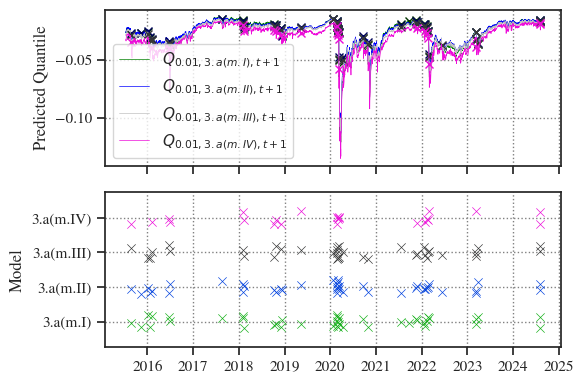

In [295]:
var_norm_mle_margin_emp = pd.read_pickle("data/var_norm_mle_v2_margin_emp.pkl")
var_norm_mle_margin_norm = pd.read_pickle("data/var_norm_mle_v2_margin_norm.pkl")
var_norm_mle_margin_t = pd.read_pickle("data/var_norm_mle_v2_margin_t.pkl")
var_norm_mle_margin_t_f0_3 = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(6,4))

evaluate_hits(mu_pf,var_norm_mle_margin_emp,ax=axs[0],plot_actual=False,color=("green","xkcd:dark green"),model="3.a(m.I)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_norm,ax=axs[0],plot_actual=False,color=("blue","xkcd:dark blue"),model="3.a(m.II)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_t,ax=axs[0],plot_actual=False,color=("silver","xkcd:dark grey"),model="3.a(m.III)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_t_f0_3,ax=axs[0],plot_actual=False,color=("xkcd:fuchsia","xkcd:fuchsia"),model="3.a(m.IV)",show_n=False)

axs[0].set_ylabel("Predicted Quantile")

evaluate_hit_clusters(mu_pf,var_norm_mle_margin_emp,ax=axs[1],color="xkcd:green")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_norm,ax=axs[1],mult=2,color="xkcd:blue")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_t,ax=axs[1],mult=3,color="xkcd:dark grey")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_t_f0_3,ax=axs[1],mult=4,color="xkcd:fuchsia")

axs[1].set_yticks([1,2,3,4])
axs[1].set_yticklabels(["3.a(m.I)","3.a(m.II)","3.a(m.III)","3.a(m.IV)"])
axs[1].set_ylim(0.25,4.75)
axs[1].legend().remove()
axs[1].set_ylabel("Model")

plt.tight_layout()

#fig.savefig("assets/hits_3a.svg")

plt.show()

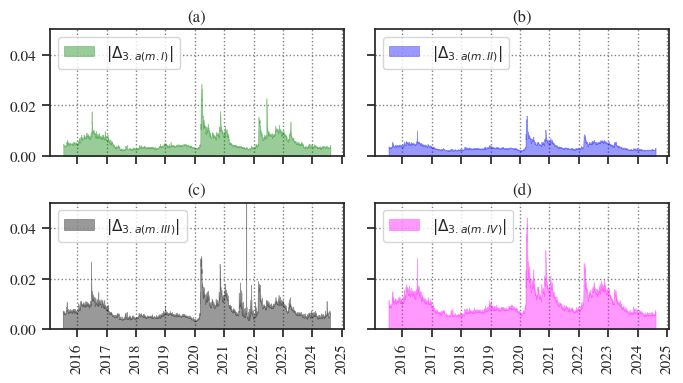

In [279]:
def plot_diff(var,es,model,color="",ax=None):
    diff = abs(es-var)
    ax.fill_between(diff.index,diff,color=color,alpha=0.4,label=rf"$|\Delta_{{{model}}}|$",linewidth=0.5)
    ax.legend()


var_norm_mle_margin_emp = pd.read_pickle("data/var_norm_mle_v2_margin_emp.pkl")
es_norm_mle_margin_emp = pd.read_pickle("data/es_norm_mle_v2_margin_emp.pkl")

var_norm_mle_margin_norm = pd.read_pickle("data/var_norm_mle_v2_margin_norm.pkl")
es_norm_mle_margin_norm = pd.read_pickle("data/es_norm_mle_v2_margin_norm.pkl")

var_norm_mle_margin_t = pd.read_pickle("data/var_norm_mle_v2_margin_t.pkl")
es_norm_mle_margin_t = pd.read_pickle("data/es_norm_mle_v2_margin_t.pkl")

var_norm_mle_margin_t_f0_3 = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")
es_norm_mle_margin_t_f0_3 = pd.read_pickle("data/es_norm_mle_v2_margin_t_f0_3.pkl")


fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True,figsize=(7,4))

plot_diff(var_norm_mle_margin_emp,es_norm_mle_margin_emp,color="green",ax=axs[0,0],model="3.a(m.I)")
plot_diff(var_norm_mle_margin_norm,es_norm_mle_margin_norm,color="blue",ax=axs[0,1],model="3.a(m.II)")
plot_diff(var_norm_mle_margin_t,es_norm_mle_margin_t,color="black",ax=axs[1,0],model="3.a(m.III)")
plot_diff(var_norm_mle_margin_t_f0_3,es_norm_mle_margin_t_f0_3,color="magenta",ax=axs[1,1],model="3.a(m.IV)")

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis="x",rotation=90)

for ax,title in zip(axs.flatten(),["(a)","(b)","(c)","(d)"]):
    ax.set_ylim(0,0.05)
    sns.move_legend(ax,"upper left")
    ax.set_title(title)

plt.tight_layout()

#fig.savefig("assets/diff_3a.svg")

plt.show()

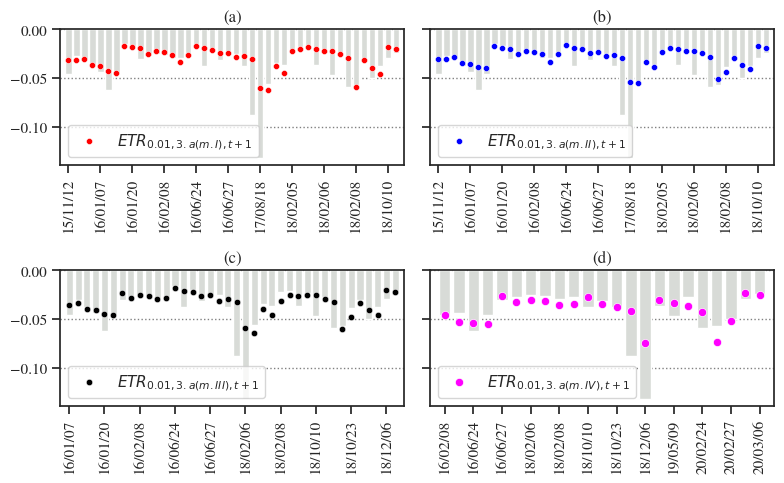

In [1067]:
import string

def plot_mu_es(mu_pf,var,es,color:str,ax=None,model=""):
    hits = simple_hits(mu_pf,var)
    hit_days = hits.loc[hits==True].index
    s = 800/len(hit_days)
    sns.barplot(mu_pf.loc[hit_days],color="xkcd:light grey",ax=ax)#,label=r"$\mu_{pf,t}$")
    sns.scatterplot(x=range(len(hit_days)),y=es.loc[hit_days].values,color=color,ax=ax,s=s,label=fr"$ETR_{{0.01,{model},t+1}}$")
    if ax:
        ax.set_xlim(left=-1,right=len(hit_days))
        ax.tick_params(axis='x', labelrotation=90)
        ax.set_xticklabels(hit_days.strftime("%y/%m/%d"))
    else:
        plt.xlim(-1,len(hit_days))
        plt.xticks(rotation=90)
    

fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,5))
plot_mu_es(mu_pf,var_norm_mle_margin_emp,es_norm_mle_margin_emp,ax=axs[0,0],color="red",model="3.a(m.I)")
plot_mu_es(mu_pf,var_norm_mle_margin_norm,es_norm_mle_margin_norm,ax=axs[0,1],color="blue",model="3.a(m.II)")
plot_mu_es(mu_pf,var_norm_mle_margin_t,es_norm_mle_margin_t,ax=axs[1,0],color="black",model="3.a(m.III)")
plot_mu_es(mu_pf,var_norm_mle_margin_t_f0_3,es_norm_mle_margin_t_f0_3,ax=axs[1,1],color="magenta",model="3.a(m.IV)")

for i,ax in enumerate(axs.flatten()):
    ax.set_title(f"({string.ascii_lowercase[i]})")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))

plt.tight_layout()

#fig.savefig("assets/es_vs_mu_3a.svg")

plt.show()

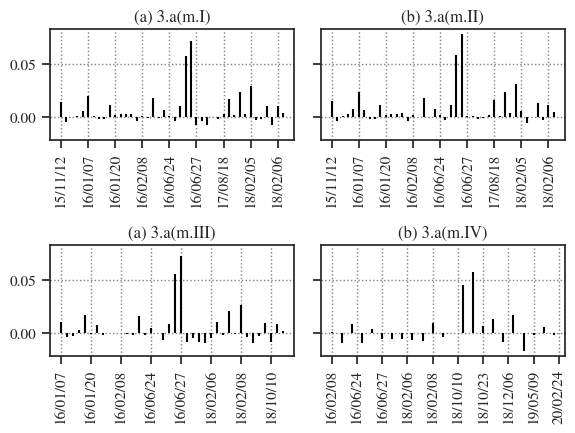

In [1095]:
fig, axs = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(6,4.5))

plot_residuals(mu_pf,var_norm_mle_margin_emp,es_norm_mle_margin_emp,axs[0,0])
plot_residuals(mu_pf,var_norm_mle_margin_norm,es_norm_mle_margin_norm,axs[0,1])
plot_residuals(mu_pf,var_norm_mle_margin_t,es_norm_mle_margin_t,axs[1,0])
plot_residuals(mu_pf,var_norm_mle_margin_t_f0_3,es_norm_mle_margin_t_f0_3,axs[1,1])

axs[0,0].set_title("(a) 3.a(m.I)")
axs[0,1].set_title("(b) 3.a(m.II)")
axs[1,0].set_title("(a) 3.a(m.III)")
axs[1,1].set_title("(b) 3.a(m.IV)")

plt.tight_layout()

#fig.savefig("assets/residuals_3a.svg")

plt.show()

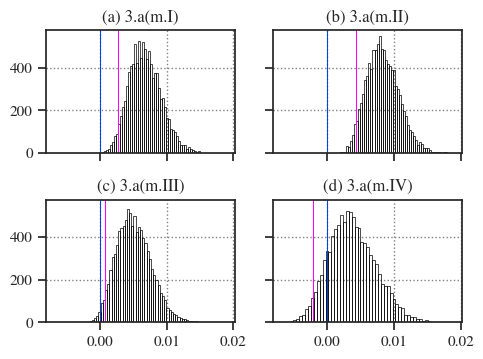

In [1101]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(5,3.75),sharey=True,sharex=True)

ci=0.99

plot_es_test(mu_pf,var_norm_mle_margin_emp,es_norm_mle_margin_emp,axs[0,0],ci=ci)
plot_es_test(mu_pf,var_norm_mle_margin_norm,es_norm_mle_margin_norm,axs[0,1],ci=ci)
plot_es_test(mu_pf,var_norm_mle_margin_t,es_norm_mle_margin_t,axs[1,0],ci=ci)
plot_es_test(mu_pf,var_norm_mle_margin_t_f0_3,es_norm_mle_margin_t_f0_3,axs[1,1],ci=ci)

axs[0,0].set_title("(a) 3.a(m.I)")
axs[0,1].set_title("(b) 3.a(m.II)")
axs[1,0].set_title("(c) 3.a(m.III)")
axs[1,1].set_title("(d) 3.a(m.IV)")

plt.tight_layout()

#fig.savefig("assets/es_test_3a.svg")
plt.show()

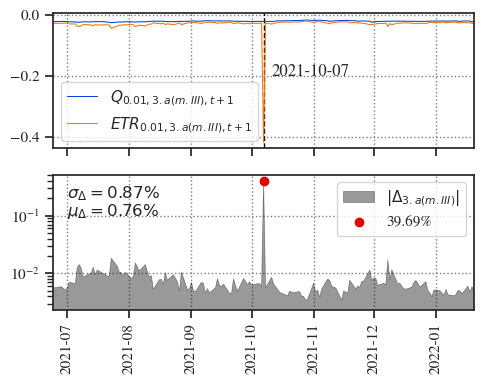

2021-10-07 00:00:00 0.396868075952255 44.86368974618527


In [518]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(5,4))

var = -np.log(-1*var_norm_mle_margin_t)
es = -np.log(-1*es_norm_mle_margin_t)

x_max = diff.idxmax()
v_max = diff.loc[diff.idxmax()]

axs[0].axvline(x_max,linestyle="dashed",color="black")
axs[0].plot(var_norm_mle_margin_t,label=r"$Q_{0.01,3.a(m.III),t+1}$",color="xkcd:blue",linewidth=0.75)
axs[0].plot(es_norm_mle_margin_t,label=r"$ETR_{0.01,3.a(m.III),t+1}$",color="xkcd:orange",linewidth=0.75)

#axs[0].plot(var)
#axs[0].plot(es)

lbl_pos = x_max + pd.offsets.BDay(2)
axs[0].annotate(x_max.strftime("%Y-%m-%d"),(lbl_pos,-0.2))
axs[0].set_ylim(auto="True")
axs[0].legend()

plot_diff(var_norm_mle_margin_t,es_norm_mle_margin_t,color="black",ax=axs[1],model="3.a(m.III)")
diff = abs(es_norm_mle_margin_t - var_norm_mle_margin_t)

axs[1].scatter(x_max,v_max,color="xkcd:red",label=f"{v_max*100:.2f}%")
axs[1].set_yscale("log")

xlim = (x_max + pd.offsets.BDay(-75),x_max + pd.offsets.BDay(75))
std = diff.std()
mu = diff.mean()

n = (v_max-mu)/std

t_pos = xlim[0] + pd.offsets.BDay(5)
axs[1].text(t_pos,10**(-1),rf"$\mu_\Delta = {mu*100:.2f}\%$")
axs[1].text(t_pos,5**(-1),rf"$\sigma_\Delta = {std*100:.2f}\%$")

axs[1].set_xlim(xlim)

plt.legend()
sns.move_legend(axs[1],"upper right")
plt.xticks(rotation=90)
plt.tight_layout()
#fig.savefig("assets/diff_3a_outlier.svg")

plt.show()
print(x_max,v_max,n)

In [693]:
from sklearn.metrics import r2_score, mean_squared_error

In [710]:
hits = simple_hits(mu_pf,var_t_mom_margin_t_f0_3)
dates = hits.loc[hits==True].index

rmse = mean_squared_error(mu_pf.loc[dates],es_t_mom_margin_t_f0_3.loc[dates])
r2 = r2_score(mu_pf.loc[dates],es_cov.loc[dates])

rmse, r2

(0.00033695846879000925, -0.22475029472975794)

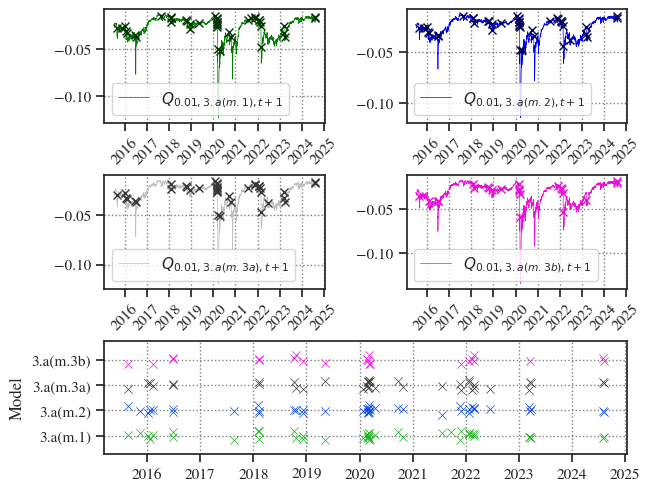

In [160]:
var_norm_mle_margin_emp = pd.read_pickle("data/var_norm_mle_v2_margin_emp.pkl")
var_norm_mle_margin_norm = pd.read_pickle("data/var_norm_mle_v2_margin_norm.pkl")
var_norm_mle_margin_t = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_free.pkl")
var_norm_mle_margin_t_f0_3 = pd.read_pickle("data/var_norm_mle_v2_margin_t_f0_3.pkl")

mosaic="""
AB
CD
EE
"""
fig,axs = plt.subplot_mosaic(mosaic,layout="constrained")



evaluate_hits(mu_pf,var_norm_mle_margin_emp,ax=axs["A"],plot_actual=False,color=("green","xkcd:dark green"),model="3.a(m.1)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_norm,ax=axs["B"],plot_actual=False,color=("blue","xkcd:dark blue"),model="3.a(m.2)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_t,ax=axs["C"],plot_actual=False,color=("silver","xkcd:dark grey"),model="3.a(m.3a)",show_n=False)
evaluate_hits(mu_pf,var_norm_mle_margin_t_f0_3,ax=axs["D"],plot_actual=False,color=("xkcd:fuchsia","xkcd:fuchsia"),model="3.a(m.3b)",show_n=False)

evaluate_hit_clusters(mu_pf,var_norm_mle_margin_emp,ax=axs["E"],color="xkcd:green")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_norm,ax=axs["E"],mult=2,color="xkcd:blue")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_t,ax=axs["E"],mult=3,color="xkcd:dark grey")
evaluate_hit_clusters(mu_pf,var_norm_mle_margin_t_f0_3,ax=axs["E"],mult=4,color="xkcd:fuchsia")

for a in "ABCD":
    axs[a].tick_params(axis='x', labelrotation=45)

axs["E"].set_yticks([1,2,3,4])
axs["E"].set_yticklabels(["3.a(m.1)","3.a(m.2)","3.a(m.3a)","3.a(m.3b)"])
axs["E"].set_ylim(0.25,4.75)
axs["E"].legend().remove()
axs["E"].set_ylabel("Model")

plt.show()

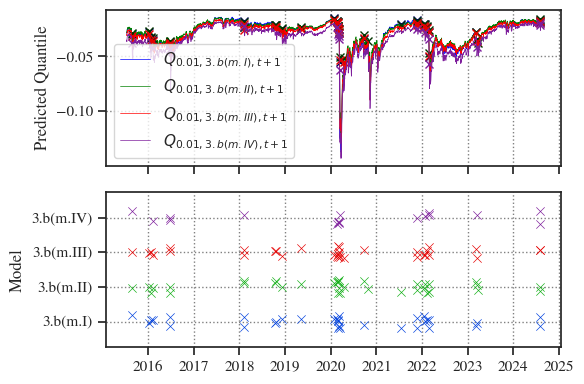

In [296]:
var_t_mle_margin_emp = pd.read_pickle("data/var_t_mle_v2_margin_emp.pkl")
var_t_mle_margin_norm = pd.read_pickle("data/var_t_mle_v2_margin_norm.pkl")
var_t_mle_margin_t = pd.read_pickle("data/var_t_mle_v2_margin_t.pkl")
var_t_mle_margin_t_f0_3 = pd.read_pickle("data/var_t_mle_v2_margin_t_f0_3.pkl")

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(6,4))

evaluate_hits(mu_pf,var_t_mle_margin_emp,ax=axs[0],plot_actual=False,color=("blue","xkcd:dark blue"),model="3.b(m.I)",show_n=False)
evaluate_hits(mu_pf,var_t_mle_margin_norm,ax=axs[0],plot_actual=False,color=("green","xkcd:dark green"),model="3.b(m.II)",show_n=False)
evaluate_hits(mu_pf,var_t_mle_margin_t,ax=axs[0],plot_actual=False,color=("red","xkcd:red"),model="3.b(m.III)",show_n=False)
evaluate_hits(mu_pf,var_t_mle_margin_t_f0_3,ax=axs[0],plot_actual=False,color=("xkcd:purple","xkcd:purple"),model="3.b(m.IV)",show_n=False)

axs[0].set_ylabel("Predicted Quantile")

evaluate_hit_clusters(mu_pf,var_t_mle_margin_emp,ax=axs[1],color="xkcd:blue")
evaluate_hit_clusters(mu_pf,var_t_mle_margin_norm,ax=axs[1],mult=2,color="xkcd:green")
evaluate_hit_clusters(mu_pf,var_t_mle_margin_t,ax=axs[1],mult=3,color="xkcd:red")
evaluate_hit_clusters(mu_pf,var_t_mle_margin_t_f0_3,ax=axs[1],mult=4,color="xkcd:purple")

axs[1].set_yticks([1,2,3,4])
axs[1].set_yticklabels(["3.b(m.I)","3.b(m.II)","3.b(m.III)","3.b(m.IV)"])
axs[1].set_ylim(0.25,4.75)
axs[1].legend().remove()
axs[1].set_ylabel("Model")

plt.tight_layout()

#fig.savefig("assets/hits_3b.svg")

plt.show()

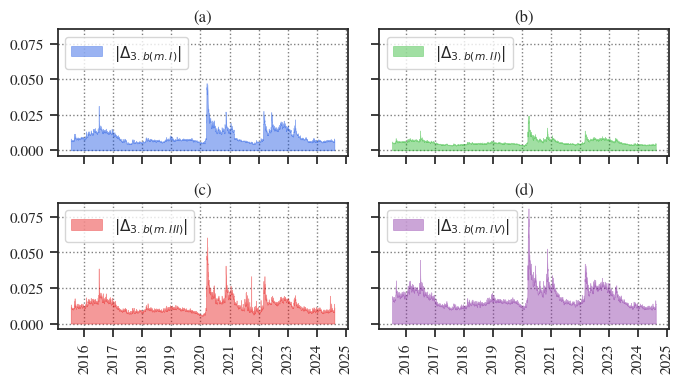

In [291]:

var_t_mle_margin_emp = pd.read_pickle("data/var_t_mle_v2_margin_emp.pkl")
es_t_mle_margin_emp = pd.read_pickle("data/es_t_mle_v2_margin_emp.pkl")

var_t_mle_margin_norm = pd.read_pickle("data/var_t_mle_v2_margin_norm.pkl")
es_t_mle_margin_norm = pd.read_pickle("data/es_t_mle_v2_margin_norm.pkl")

var_t_mle_margin_t = pd.read_pickle("data/var_t_mle_v2_margin_t.pkl")
es_t_mle_margin_t = pd.read_pickle("data/es_t_mle_v2_margin_t.pkl")

var_t_mle_margin_t_f0_3 = pd.read_pickle("data/var_t_mle_v2_margin_t_f0_3.pkl")
es_t_mle_margin_t_f0_3 = pd.read_pickle("data/es_t_mle_v2_margin_t_f0_3.pkl")


fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True,figsize=(7,4))

plot_diff(var_t_mle_margin_emp,es_t_mle_margin_emp,color="xkcd:blue",ax=axs[0,0],model="3.b(m.I)")
plot_diff(var_t_mle_margin_norm,es_t_mle_margin_norm,color="xkcd:green",ax=axs[0,1],model="3.b(m.II)")
plot_diff(var_t_mle_margin_t,es_t_mle_margin_t,color="xkcd:red",ax=axs[1,0],model="3.b(m.III)")
plot_diff(var_t_mle_margin_t_f0_3,es_t_mle_margin_t_f0_3,color="xkcd:purple",ax=axs[1,1],model="3.b(m.IV)")

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis="x",rotation=90)

for ax,title in zip(axs.flatten(),["(a)","(b)","(c)","(d)"]):
    #ax.set_ylim(0,0.05)
    sns.move_legend(ax,"upper left")
    ax.set_title(title)

plt.tight_layout()

#fig.savefig("assets/diff_3b.svg")

plt.show()

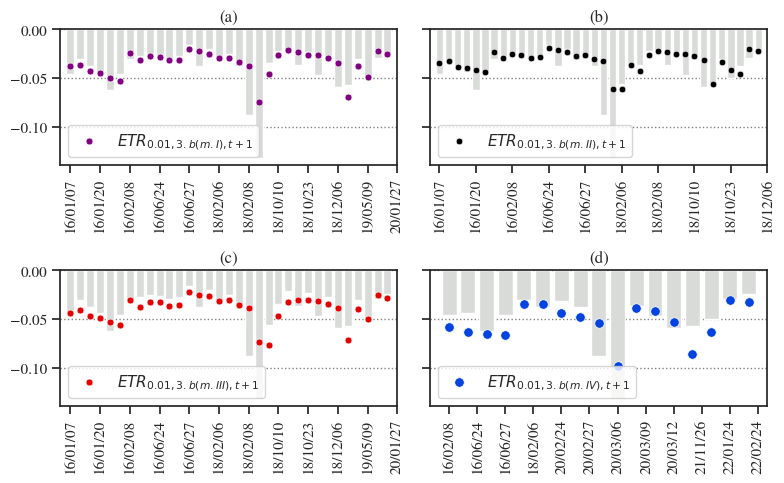

In [1069]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,5))
plot_mu_es(mu_pf,var_t_mle_margin_emp,es_t_mle_margin_emp,ax=axs[0,0],color="purple",model="3.b(m.I)")
plot_mu_es(mu_pf,var_t_mle_margin_norm,es_t_mle_margin_norm,ax=axs[0,1],color="black",model="3.b(m.II)")
plot_mu_es(mu_pf,var_t_mle_margin_t,es_t_mle_margin_t,ax=axs[1,0],color="xkcd:red",model="3.b(m.III)")
plot_mu_es(mu_pf,var_t_mle_margin_t_f0_3,es_t_mle_margin_t_f0_3,ax=axs[1,1],color="xkcd:blue",model="3.b(m.IV)")

for i,ax in enumerate(axs.flatten()):
    ax.set_title(f"({string.ascii_lowercase[i]})")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))

plt.tight_layout()

#fig.savefig("assets/es_vs_mu_3b.svg")

plt.show()

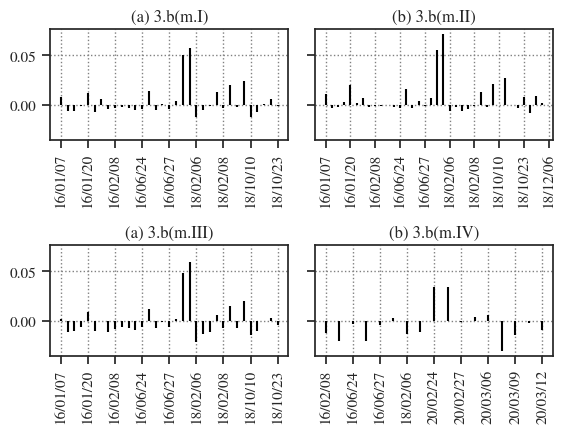

In [1098]:
fig, axs = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(6,4.5))

plot_residuals(mu_pf,var_t_mle_margin_emp,es_t_mle_margin_emp,axs[0,0])
plot_residuals(mu_pf,var_t_mle_margin_norm,es_t_mle_margin_norm,axs[0,1])
plot_residuals(mu_pf,var_t_mle_margin_t,es_t_mle_margin_t,axs[1,0])
plot_residuals(mu_pf,var_t_mle_margin_t_f0_3,es_t_mle_margin_t_f0_3,axs[1,1])

axs[0,0].set_title("(a) 3.b(m.I)")
axs[0,1].set_title("(b) 3.b(m.II)")
axs[1,0].set_title("(a) 3.b(m.III)")
axs[1,1].set_title("(b) 3.b(m.IV)")

plt.tight_layout()

#fig.savefig("assets/residuals_3b.svg")

plt.show()

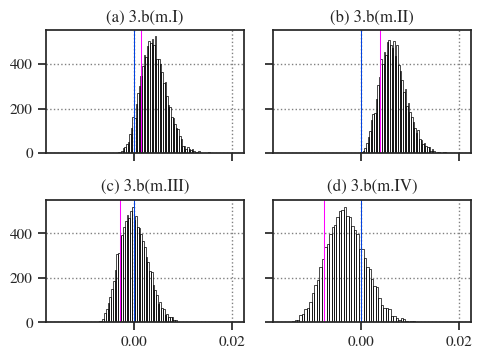

In [1107]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(5,3.75),sharey=True,sharex=True)

ci=0.90

plot_es_test(mu_pf,var_t_mle_margin_emp,es_t_mle_margin_emp,axs[0,0],ci=ci)
plot_es_test(mu_pf,var_t_mle_margin_norm,es_t_mle_margin_norm,axs[0,1],ci=ci)
plot_es_test(mu_pf,var_t_mle_margin_t,es_t_mle_margin_t,axs[1,0],ci=ci)
plot_es_test(mu_pf,var_t_mle_margin_t_f0_3,es_t_mle_margin_t_f0_3,axs[1,1],ci=ci)

axs[0,0].set_title("(a) 3.b(m.I)")
axs[0,1].set_title("(b) 3.b(m.II)")
axs[1,0].set_title("(c) 3.b(m.III)")
axs[1,1].set_title("(d) 3.b(m.IV)")

plt.tight_layout()

#fig.savefig("assets/es_test_3b.svg")
plt.show()

In [ ]:
hits = simple_hits(mu_pf,var_norm_mle_margin_emp)
dates = hits.loc[hits==True].index

rmse = mean_squared_error(mu_pf.loc[dates],es_norm_mle_margin_emp.loc[dates])
r2 = r2_score(mu_pf.loc[dates],es_hist.loc[dates])

rmse, r2

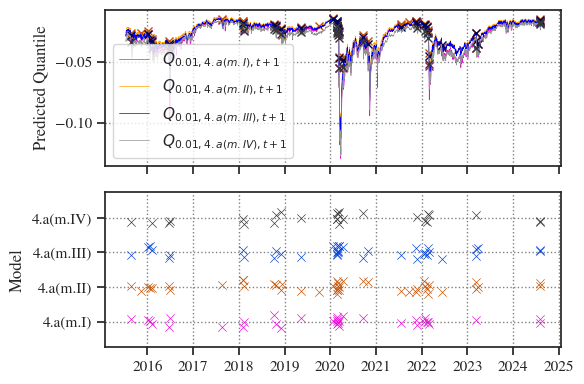

In [299]:
var_norm_mom_margin_emp = pd.read_pickle("data/var_norm_mom_v2_margin_emp.pkl")
var_norm_mom_margin_norm = pd.read_pickle("data/var_norm_mom_v2_margin_norm.pkl")
var_norm_mom_margin_t = pd.read_pickle("data/var_norm_mom_v2_margin_t.pkl")
var_norm_mom_margin_t_f0_3 = pd.read_pickle("data/var_norm_mom_v2_margin_t_f0_3.pkl")

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(6,4))

evaluate_hits(mu_pf,var_norm_mom_margin_emp,ax=axs[0],plot_actual=False,color=("xkcd:fuchsia","xkcd:magenta"),model="4.a(m.I)",show_n=False)
evaluate_hits(mu_pf,var_norm_mom_margin_norm,ax=axs[0],plot_actual=False,color=("orange","xkcd:dark orange"),model="4.a(m.II)",show_n=False)
evaluate_hits(mu_pf,var_norm_mom_margin_t,ax=axs[0],plot_actual=False,color=("blue","xkcd:dark blue"),model="4.a(m.III)",show_n=False)
evaluate_hits(mu_pf,var_norm_mom_margin_t_f0_3,ax=axs[0],plot_actual=False,color=("xkcd:grey","xkcd:dark grey"),model="4.a(m.IV)",show_n=False)

axs[0].set_ylabel("Predicted Quantile")

evaluate_hit_clusters(mu_pf,var_norm_mom_margin_emp,ax=axs[1],color="xkcd:fuchsia")
evaluate_hit_clusters(mu_pf,var_norm_mom_margin_norm,ax=axs[1],mult=2,color="xkcd:dark orange")
evaluate_hit_clusters(mu_pf,var_norm_mom_margin_t,ax=axs[1],mult=3,color="xkcd:blue")
evaluate_hit_clusters(mu_pf,var_norm_mom_margin_t_f0_3,ax=axs[1],mult=4,color="xkcd:dark grey")

axs[1].set_yticks([1,2,3,4])
axs[1].set_yticklabels(["4.a(m.I)","4.a(m.II)","4.a(m.III)","4.a(m.IV)"])
axs[1].set_ylim(0.25,4.75)
axs[1].legend().remove()
axs[1].set_ylabel("Model")

plt.tight_layout()

#fig.savefig("assets/hits_4a.svg")

plt.show()

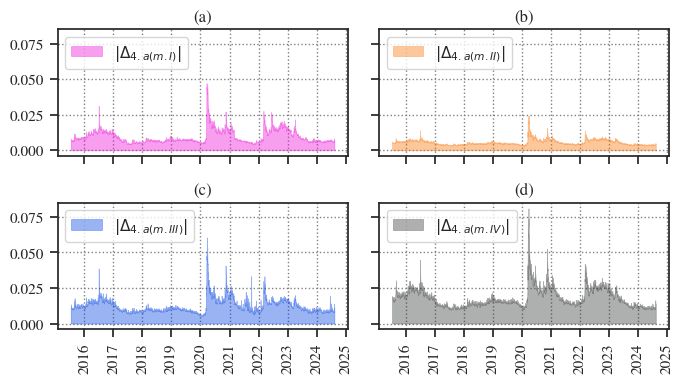

In [302]:
var_norm_mom_margin_emp = pd.read_pickle("data/var_norm_mom_v2_margin_emp.pkl")
es_norm_mom_margin_emp = pd.read_pickle("data/es_norm_mom_v2_margin_emp.pkl")

var_norm_mom_margin_norm = pd.read_pickle("data/var_norm_mom_v2_margin_norm.pkl")
es_norm_mom_margin_norm = pd.read_pickle("data/es_norm_mom_v2_margin_norm.pkl")

var_norm_mom_margin_t = pd.read_pickle("data/var_norm_mom_v2_margin_t.pkl")
es_norm_mom_margin_t = pd.read_pickle("data/es_norm_mom_v2_margin_t.pkl")

var_norm_mom_margin_t_f0_3 = pd.read_pickle("data/var_norm_mom_v2_margin_t_f0_3.pkl")
es_norm_mom_margin_t_f0_3 = pd.read_pickle("data/es_norm_mom_v2_margin_t_f0_3.pkl")


fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True,figsize=(7,4))

plot_diff(var_t_mle_margin_emp,es_t_mle_margin_emp,color="xkcd:fuchsia",ax=axs[0,0],model="4.a(m.I)")
plot_diff(var_t_mle_margin_norm,es_t_mle_margin_norm,color="xkcd:orange",ax=axs[0,1],model="4.a(m.II)")
plot_diff(var_t_mle_margin_t,es_t_mle_margin_t,color="xkcd:blue",ax=axs[1,0],model="4.a(m.III)")
plot_diff(var_t_mle_margin_t_f0_3,es_t_mle_margin_t_f0_3,color="xkcd:dark grey",ax=axs[1,1],model="4.a(m.IV)")

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis="x",rotation=90)

for ax,title in zip(axs.flatten(),["(a)","(b)","(c)","(d)"]):
    #ax.set_ylim(0,0.05)
    sns.move_legend(ax,"upper left")
    ax.set_title(title)

plt.tight_layout()

#fig.savefig("assets/diff_4a.svg")

plt.show()

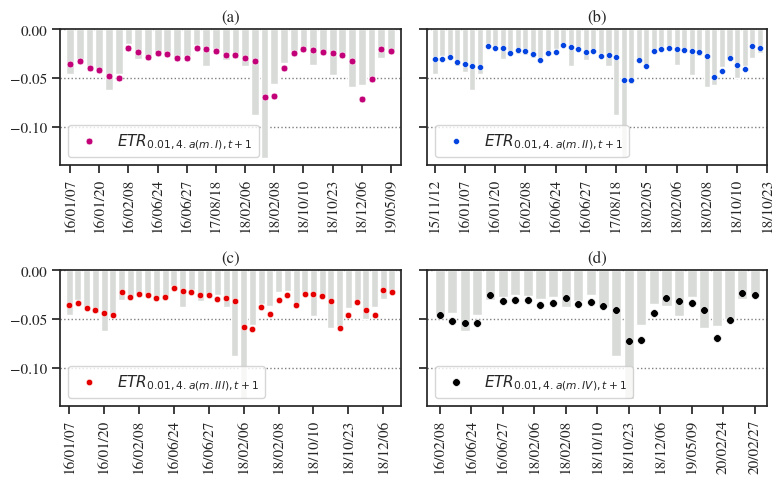

In [1071]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,5))
plot_mu_es(mu_pf,var_norm_mom_margin_emp,es_norm_mom_margin_emp,ax=axs[0,0],color="xkcd:magenta",model="4.a(m.I)")
plot_mu_es(mu_pf,var_norm_mom_margin_norm,es_norm_mom_margin_norm,ax=axs[0,1],color="xkcd:blue",model="4.a(m.II)")
plot_mu_es(mu_pf,var_norm_mom_margin_t,es_norm_mom_margin_t,ax=axs[1,0],color="xkcd:red",model="4.a(m.III)")
plot_mu_es(mu_pf,var_norm_mom_margin_t_f0_3,es_norm_mom_margin_t_f0_3,ax=axs[1,1],color="xkcd:black",model="4.a(m.IV)")

for i,ax in enumerate(axs.flatten()):
    ax.set_title(f"({string.ascii_lowercase[i]})")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))

plt.tight_layout()

#fig.savefig("assets/es_vs_mu_4a.svg")

plt.show()

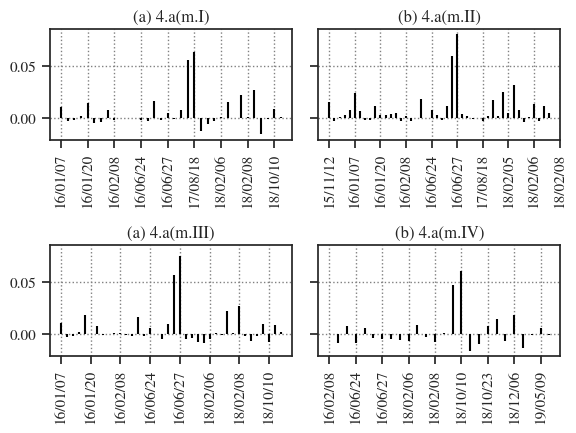

In [1109]:
fig, axs = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(6,4.5))

plot_residuals(mu_pf,var_norm_mom_margin_emp,es_norm_mom_margin_emp,axs[0,0])
plot_residuals(mu_pf,var_norm_mom_margin_norm,es_norm_mom_margin_norm,axs[0,1])
plot_residuals(mu_pf,var_norm_mom_margin_t,es_norm_mom_margin_t,axs[1,0])
plot_residuals(mu_pf,var_norm_mom_margin_t_f0_3,es_norm_mom_margin_t_f0_3,axs[1,1])

axs[0,0].set_title("(a) 4.a(m.I)")
axs[0,1].set_title("(b) 4.a(m.II)")
axs[1,0].set_title("(a) 4.a(m.III)")
axs[1,1].set_title("(b) 4.a(m.IV)")

plt.tight_layout()

#fig.savefig("assets/residuals_4a.svg")

plt.show()

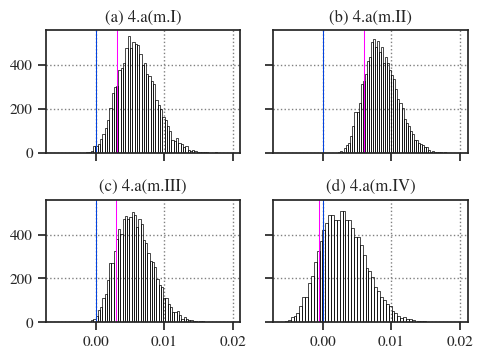

In [1120]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(5,3.75),sharey=True,sharex=True)

ci=0.90

plot_es_test(mu_pf,var_norm_mom_margin_emp,es_norm_mom_margin_emp,axs[0,0],ci=ci)
plot_es_test(mu_pf,var_norm_mom_margin_norm,es_norm_mom_margin_norm,axs[0,1],ci=ci)
plot_es_test(mu_pf,var_norm_mom_margin_t,es_norm_mom_margin_t,axs[1,0],ci=ci)
plot_es_test(mu_pf,var_norm_mom_margin_t_f0_3,es_norm_mom_margin_t_f0_3,axs[1,1],ci=ci)

axs[0,0].set_title("(a) 4.a(m.I)")
axs[0,1].set_title("(b) 4.a(m.II)")
axs[1,0].set_title("(c) 4.a(m.III)")
axs[1,1].set_title("(d) 4.a(m.IV)")

plt.tight_layout()

#fig.savefig("assets/es_test_4a.svg")
plt.show()

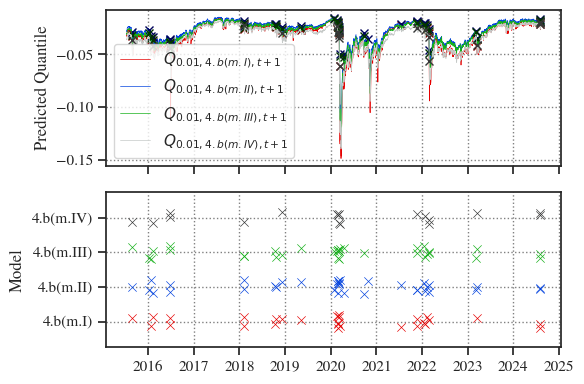

In [310]:
var_t_mom_margin_emp = pd.read_pickle("data/var_t_mom_v2_margin_emp.pkl")
var_t_mom_margin_norm = pd.read_pickle("data/var_t_mom_v2_margin_norm.pkl")
var_t_mom_margin_t = pd.read_pickle("data/var_t_mom_v2_margin_t.pkl")
var_t_mom_margin_t_f0_3 = pd.read_pickle("data/var_t_mom_v2_margin_t_f0_3.pkl")

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(6,4))

evaluate_hits(mu_pf,var_t_mom_margin_emp,ax=axs[0],plot_actual=False,color=("xkcd:red","xkcd:dark red"),model="4.b(m.I)",show_n=False)
evaluate_hits(mu_pf,var_t_mom_margin_norm,ax=axs[0],plot_actual=False,color=("xkcd:blue","xkcd:dark blue"),model="4.b(m.II)",show_n=False)
evaluate_hits(mu_pf,var_t_mom_margin_t,ax=axs[0],plot_actual=False,color=("xkcd:green","xkcd:dark green"),model="4.b(m.III)",show_n=False)
evaluate_hits(mu_pf,var_t_mom_margin_t_f0_3,ax=axs[0],plot_actual=False,color=("xkcd:silver","xkcd:dark grey"),model="4.b(m.IV)",show_n=False)

axs[0].set_ylabel("Predicted Quantile")

evaluate_hit_clusters(mu_pf,var_t_mom_margin_emp,ax=axs[1],color="xkcd:red")
evaluate_hit_clusters(mu_pf,var_t_mom_margin_norm,ax=axs[1],mult=2,color="xkcd:blue")
evaluate_hit_clusters(mu_pf,var_t_mom_margin_t,ax=axs[1],mult=3,color="xkcd:green")
evaluate_hit_clusters(mu_pf,var_t_mom_margin_t_f0_3,ax=axs[1],mult=4,color="xkcd:dark grey")

axs[1].set_yticks([1,2,3,4])
axs[1].set_yticklabels(["4.b(m.I)","4.b(m.II)","4.b(m.III)","4.b(m.IV)"])
axs[1].set_ylim(0.25,4.75)
axs[1].legend().remove()
axs[1].set_ylabel("Model")

plt.tight_layout()

#fig.savefig("assets/hits_4b.svg")

plt.show()

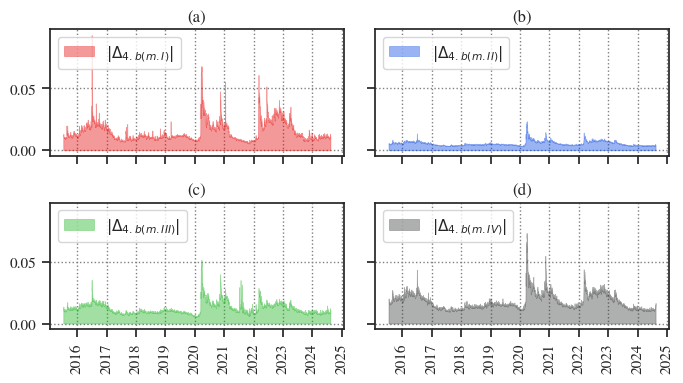

In [313]:
var_t_mom_margin_emp = pd.read_pickle("data/var_t_mom_v2_margin_emp.pkl")
es_t_mom_margin_emp = pd.read_pickle("data/es_t_mom_v2_margin_emp.pkl")

var_t_mom_margin_norm = pd.read_pickle("data/var_t_mom_v2_margin_norm.pkl")
es_t_mom_margin_norm = pd.read_pickle("data/es_t_mom_v2_margin_norm.pkl")

var_t_mom_margin_t = pd.read_pickle("data/var_t_mom_v2_margin_t.pkl")
es_t_mom_margin_t = pd.read_pickle("data/es_t_mom_v2_margin_t.pkl")

var_t_mom_margin_t_f0_3 = pd.read_pickle("data/var_t_mom_v2_margin_t_f0_3.pkl")
es_t_mom_margin_t_f0_3 = pd.read_pickle("data/es_t_mom_v2_margin_t_f0_3.pkl")

fig, axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True,figsize=(7,4))

plot_diff(var_t_mom_margin_emp,es_t_mom_margin_emp,color="xkcd:red",ax=axs[0,0],model="4.b(m.I)")
plot_diff(var_t_mom_margin_norm,es_t_mom_margin_norm,color="xkcd:blue",ax=axs[0,1],model="4.b(m.II)")
plot_diff(var_t_mom_margin_t,es_t_mom_margin_t,color="xkcd:green",ax=axs[1,0],model="4.b(m.III)")
plot_diff(var_t_mom_margin_t_f0_3,es_t_mom_margin_t_f0_3,color="xkcd:dark grey",ax=axs[1,1],model="4.b(m.IV)")

axs[1,0].tick_params(axis='x', rotation=90)
axs[1,1].tick_params(axis="x",rotation=90)

for ax,title in zip(axs.flatten(),["(a)","(b)","(c)","(d)"]):
    #ax.set_ylim(0,0.05)
    sns.move_legend(ax,"upper left")
    ax.set_title(title)

plt.tight_layout()

#fig.savefig("assets/diff_4b.svg")

plt.show()

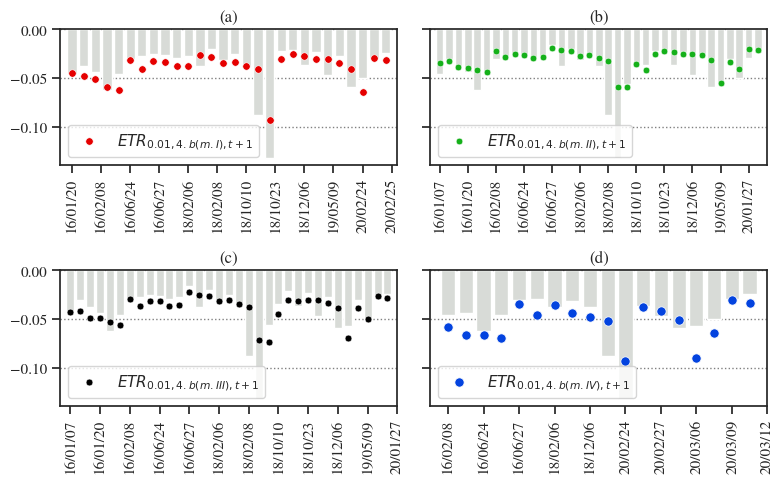

In [1073]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,5))
plot_mu_es(mu_pf,var_t_mom_margin_emp,es_t_mom_margin_emp,ax=axs[0,0],color="xkcd:red",model="4.b(m.I)")
plot_mu_es(mu_pf,var_t_mom_margin_norm,es_t_mom_margin_norm,ax=axs[0,1],color="xkcd:green",model="4.b(m.II)")
plot_mu_es(mu_pf,var_t_mom_margin_t,es_t_mom_margin_t,ax=axs[1,0],color="xkcd:black",model="4.b(m.III)")
plot_mu_es(mu_pf,var_t_mom_margin_t_f0_3,es_t_mom_margin_t_f0_3,ax=axs[1,1],color="xkcd:blue",model="4.b(m.IV)")

for i,ax in enumerate(axs.flatten()):
    ax.set_title(f"({string.ascii_lowercase[i]})")
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))

plt.tight_layout()

#fig.savefig("assets/es_vs_mu_4b.svg")

plt.show()

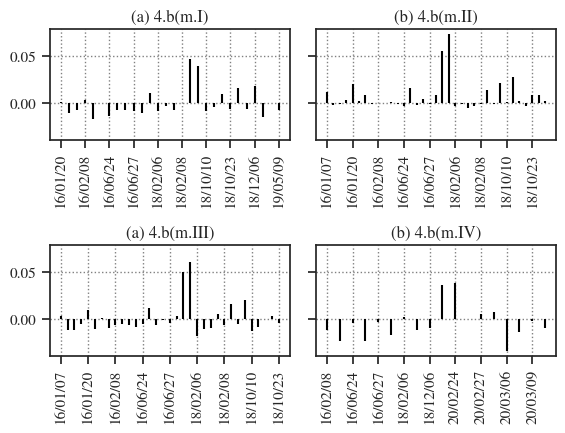

In [1121]:
fig, axs = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(6,4.5))

plot_residuals(mu_pf,var_t_mom_margin_emp,es_t_mom_margin_emp,axs[0,0])
plot_residuals(mu_pf,var_t_mom_margin_norm,es_t_mom_margin_norm,axs[0,1])
plot_residuals(mu_pf,var_t_mom_margin_t,es_t_mom_margin_t,axs[1,0])
plot_residuals(mu_pf,var_t_mom_margin_t_f0_3,es_t_mom_margin_t_f0_3,axs[1,1])

axs[0,0].set_title("(a) 4.b(m.I)")
axs[0,1].set_title("(b) 4.b(m.II)")
axs[1,0].set_title("(a) 4.b(m.III)")
axs[1,1].set_title("(b) 4.b(m.IV)")

plt.tight_layout()

#fig.savefig("assets/residuals_4b.svg")

plt.show()

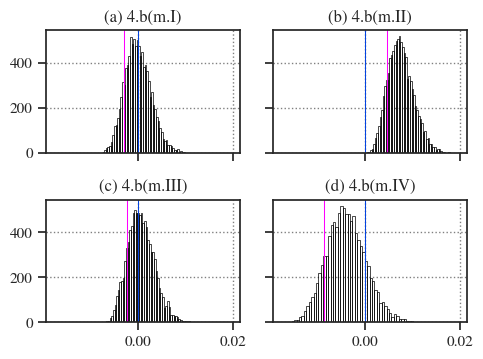

In [1124]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(5,3.75),sharey=True,sharex=True)

ci=0.90

plot_es_test(mu_pf,var_t_mom_margin_emp,es_t_mom_margin_emp,axs[0,0],ci=ci)
plot_es_test(mu_pf,var_t_mom_margin_norm,es_t_mom_margin_norm,axs[0,1],ci=ci)
plot_es_test(mu_pf,var_t_mom_margin_t,es_t_mom_margin_t,axs[1,0],ci=ci)
plot_es_test(mu_pf,var_t_mom_margin_t_f0_3,es_t_mom_margin_t_f0_3,axs[1,1],ci=ci)

axs[0,0].set_title("(a) 4.b(m.I)")
axs[0,1].set_title("(b) 4.b(m.II)")
axs[1,0].set_title("(c) 4.b(m.III)")
axs[1,1].set_title("(d) 4.b(m.IV)")

plt.tight_layout()

#fig.savefig("assets/es_test_4b.svg")
plt.show()

In [797]:
#common hit days among all models

l = [
simple_hits(mu_pf,var_cov),
simple_hits(mu_pf,var_hist),

simple_hits(mu_pf,var_norm_mle_margin_emp),
simple_hits(mu_pf,var_norm_mle_margin_norm),
simple_hits(mu_pf,var_norm_mle_margin_t),
simple_hits(mu_pf,var_norm_mle_margin_t_f0_3),

simple_hits(mu_pf,var_t_mle_margin_emp),
simple_hits(mu_pf,var_t_mle_margin_norm),
simple_hits(mu_pf,var_t_mle_margin_t),
simple_hits(mu_pf,var_t_mle_margin_t_f0_3),

simple_hits(mu_pf,var_norm_mom_margin_emp),
simple_hits(mu_pf,var_norm_mom_margin_norm),
simple_hits(mu_pf,var_norm_mom_margin_t),
simple_hits(mu_pf,var_norm_mom_margin_t_f0_3),

simple_hits(mu_pf,var_t_mom_margin_emp),
simple_hits(mu_pf,var_t_mom_margin_norm),
simple_hits(mu_pf,var_t_mom_margin_t),
simple_hits(mu_pf,var_t_mom_margin_t_f0_3)
]
df = pd.DataFrame(l).T
common_hits = df.all(axis=1)
common_hits.loc[common_hits==True]

2015-08-24    True
2016-02-08    True
2016-06-24    True
2016-06-27    True
2018-02-06    True
2020-02-24    True
2020-02-27    True
2020-03-06    True
2020-03-09    True
2020-03-12    True
2021-11-26    True
2022-01-24    True
2022-02-24    True
2023-03-15    True
2024-08-02    True
2024-08-05    True
dtype: bool

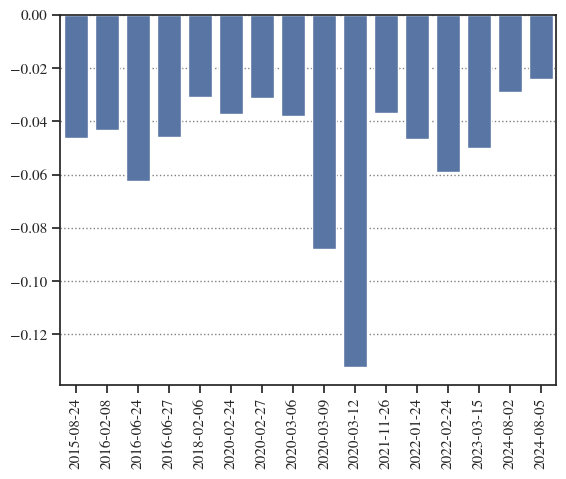

In [806]:
extreme_events = mu_pf.loc[common_hits.loc[common_hits==True].index]
sns.barplot(extreme_events)
plt.xticks(rotation=90)
plt.show()

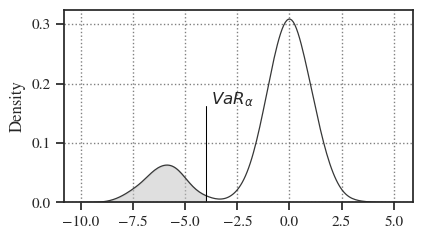

In [232]:
from scipy.stats import norm

a1 = np.random.normal(size=5000)
a2 = np.random.normal(size=1000,loc=-6)
a = np.append(a1,a2)

var = -4

fig, ax = plt.subplots(figsize=(4.5,2.5))

kde = sns.kdeplot(a,ax=ax,linewidth=0.9,color="xkcd:dark grey")

xy_tail = np.array([[x,y] for x,y in kde._children[0]._xy if x <= var])
ax.fill_between(xy_tail[:,0],xy_tail[:,1],color="silver",alpha=0.5)

ax.axvline(x=var,ymax=0.5,color="black",linewidth=0.75)
ax.annotate(r"$VaR_\alpha$",(var+0.25, 0.165))

#fig.savefig("assets/es_tail_risk.svg")

plt.show()


In [201]:
y = np.array([[x,y] for x,y in kde._children[0]._xy if x <= var])


# Performance

In [1]:
import numpy as np
data = np.random.uniform(size=(250,20))

In [3]:
from models.Copulae import normalCopulaSimulation

In [4]:
copula=normalCopulaSimulation(dispstr="un")

In [391]:
%%timeit -r 5 -n 1
#copula.fit(data,method="mpl",pseudo=False)

53.2 s ± 1 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [392]:
%%timeit -r 5 -n 1
#copula.predict(n=1e6,anti=False)

3.46 s ± 457 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [7]:
%%timeit -r 5 -n 1
copula.fit(data,method="irho")

24.6 ms ± 3.77 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
%%timeit -r 5 -n 1
copula.predict(n=1e6,anti=False)

3.2 s ± 204 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [9]:
from models.Copulae import tCopulaSimulation

In [17]:
#tcopula = tCopulaSimulation(dispstr="un")
tcopula = tCopulaSimulation(dispstr="un",df=3,df_fixed=True)

In [11]:
%%timeit -r 1 -n 1
tcopula.fit(data,method="mpl",pseudo=False)

12min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
%%timeit -r 5 -n 1
tcopula.predict(n=1e6,anti=False)

6.07 s ± 266 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [18]:
%%timeit -r 5 -n 1
tcopula.fit(data,method="itau")

371 ms ± 21.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [20]:
%%timeit -r 5 -n 1
tcopula.predict(n=1e6,anti=False)

6.64 s ± 230 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [21]:
from tools.Transformations import ppf_transform

In [23]:
sample = np.random.uniform(size=(int(2e6),20))
data = np.random.standard_t(3,size=(250,20))

In [26]:
%%timeit -r 5 -n 1
ppf_transform(sample,data,distribution="emp")

5.37 s ± 99.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [27]:
%%timeit -r 5 -n 1
ppf_transform(sample,data,distribution="norm")

2.4 s ± 544 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -r 5 -n 1
ppf_transform(sample,data,distribution="t")

1min 27s ± 1.21 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
%%timeit -r 5 -n 1
ppf_transform(sample,data,distribution="t",f0=3)

1min 23s ± 800 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
#Plot Performance over dimension 250 x n 

In [319]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from models.Copulae import normalCopulaSimulation, tCopulaSimulation
from tqdm import tqdm

sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

In [350]:
copula = normalCopulaSimulation(dispstr="un")
#copula = tCopulaSimulation(dispstr="un",df=3,df_fixed=True)

t = []
x = [2,4,8,16,24,32,40]
for dim in tqdm(x):
    data = np.random.uniform(size=(250,dim))
    start_fit = time.time()
    copula.fit(data[:,:dim],method="irho",pseudo=False)
    end_fit = time.time()
    start_predict = time.time()
    copula.predict(n=1e6,anti=False)
    end_predict = time.time()
    t.append((end_fit-start_fit,end_predict-start_predict))

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.75s/it]


In [351]:
#Save x,t as pd.Series
import pandas as pd
df_perf_norm_mom = pd.DataFrame(t,index=x,columns=["fit","predict"])
df_perf_norm_mom.to_pickle("data/df_perf_norm_mom.pkl")

In [320]:
copula = tCopulaSimulation(dispstr="un")

In [321]:
t = []
x = [2,4,8,16]
for dim in tqdm(x):
    data = np.random.uniform(size=(250,dim))
    start_fit = time.time()
    copula.fit(data[:,:dim],method="mpl",pseudo=False)
    end_fit = time.time()
    start_predict = time.time()
    copula.predict(n=1e6,anti=False)
    end_predict = time.time()
    t.append([end_fit-start_fit,end_predict-start_predict])

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.75s/it]


In [322]:
df_perf_t_mle = pd.DataFrame(t,index=x,columns=["fit","predict"])
#df_perf_t_mle.to_pickle("data/df_perf_t_mle.pkl")

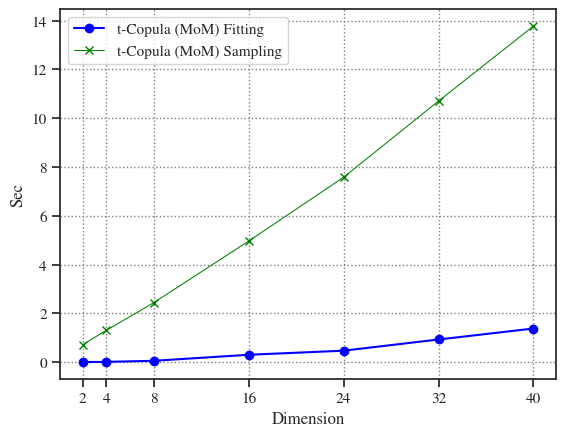

In [12]:

y_0 = [elem[0] for elem in t]
y_1 = [elem[1] for elem in t]

fit = np.polyfit(x, np.log(y_0), 1)
a,b = fit[1],fit[0]
f = lambda x: np.exp(a)*np.exp(b)**x

x_reg = np.linspace(0,40,100)
y_reg = [f(n) for n in x_reg]

fig, ax = plt.subplots()
ax.plot(x,y_0,label="t-Copula (MoM) Fitting",color="blue",marker="o")
#ax.plot(x_reg,y_reg,label=r"$f(x) = a \cdot b^{x}$",color="blue",linewidth=0.75)
ax.plot(x,y_1,label="t-Copula (MoM) Sampling",color="green",marker="x",linewidth=0.75)
ax.set_xticks(x)
ax.set_xlabel("Dimension")
ax.set_ylabel("Sec")
plt.legend()

#fig.savefig("assets/t_mom_copula_performance.svg")

plt.show()
#print(f"a = {a} \nb = {b}")

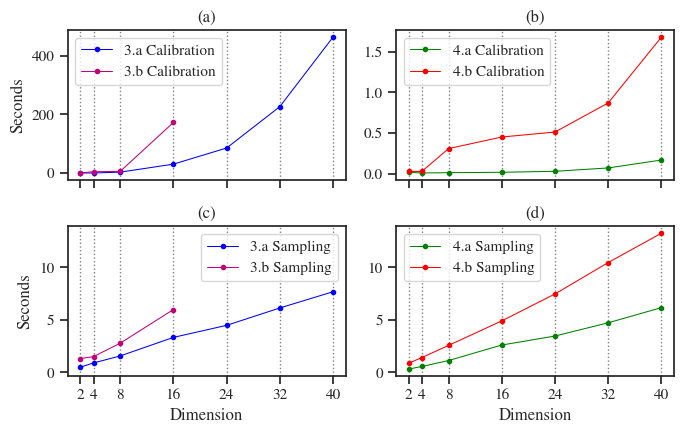

In [353]:
df_perf_norm_mle = pd.read_pickle("data/df_perf_norm_mle.pkl")
df_perf_norm_mom = pd.read_pickle("data/df_perf_norm_mom.pkl")
df_perf_t_mle = pd.read_pickle("data/df_perf_t_mle.pkl")
df_perf_t_mom = pd.read_pickle("data/df_perf_t_mom.pkl")

fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7,4.5),sharex=True)
plt.rcParams.update({'lines.linewidth': 0.75})

axs[0,0].plot(df_perf_norm_mle.loc[:,"fit"],marker=".",label="3.a Calibration",color="blue")
axs[0,0].plot(df_perf_t_mle.loc[:,"fit"],marker=".",label="3.b Calibration",color="xkcd:magenta")
axs[0,0].set_title("(a)")
axs[0,0].set_ylabel("Seconds")

axs[0,1].plot(df_perf_norm_mom.loc[:,"fit"],marker=".",label="4.a Calibration",color="green")
axs[0,1].plot(df_perf_t_mom.loc[:,"fit"],marker=".",label="4.b Calibration",color="red")
axs[0,1].set_title("(b)")

axs[1,0].plot(df_perf_norm_mle.loc[:,"predict"],marker=".",color="blue",label="3.a Sampling")
axs[1,0].plot(df_perf_t_mle.loc[:,"predict"],marker=".",color="xkcd:magenta",label="3.b Sampling")
axs[1,0].set_xlabel("Dimension")
axs[1,0].set_xticks(df_perf_norm_mle.index)
axs[1,0].set_title("(c)")
axs[1,0].set_ylabel("Seconds")

axs[1,1].plot(df_perf_norm_mom.loc[:,"predict"],marker=".",color="green",label="4.a Sampling")
axs[1,1].plot(df_perf_t_mom.loc[:,"predict"],marker=".",color="red",label="4.b Sampling")
axs[1,1].set_xticks(df_perf_norm_mle.index)
axs[1,1].set_xlabel("Dimension")
axs[1,1].set_title("(d)")

for ax in axs.flatten():
    #ax.set_ylabel("Seconds")
    ax.legend()
    ax.grid(axis='y')

sns.move_legend(axs[0,1],"upper left")
sns.move_legend(axs[1,1],"upper left")

axs[1,0].sharey(axs[1,1])

plt.tight_layout()

#fig.savefig("assets/copula_performance.svg")
plt.show()

plt.rcParams.update({'lines.linewidth': 1})

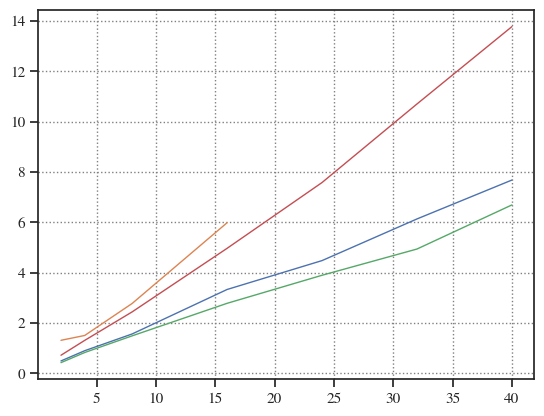

In [335]:
fig, ax = plt.subplots()

ax.plot(df_perf_norm_mle.loc[:,"predict"],label="")
ax.plot(df_perf_t_mle.loc[:,"predict"],label="")
ax.plot(df_perf_norm_mom.loc[:,"predict"],label="")
ax.plot(df_perf_t_mom.loc[:,"predict"],label="")

# $\nu$-Distribution

In [23]:
from scipy.stats import t

windows = np.load("data/adj_return_windows.npy")

dfs, mus, sds = [], [], []

for window in tqdm(windows):
    df,mu,sd=[],[],[]
    for asset in range(window.shape[1]):
        try:
            params = t.fit(window[:,asset])
        except:
            continue
        df.append(params[0])
        mu.append(params[1])
        sd.append(params[2])
    dfs.append(df)
    mus.append(mu)
    sds.append(sd)


100%|███████████████████████████████████████████████████████████████████████████████| 2622/2622 [41:31<00:00,  1.05it/s]


In [27]:
# Save to disk als dataframe
from data.data import df_tr_log_red

df_dist_f_params_nu = pd.DataFrame(data=dfs,columns=df_tr_log_red.columns)
df_dist_f_params_mu = pd.DataFrame(data=mus,columns=df_tr_log_red.columns)
df_dist_f_params_sd = pd.DataFrame(data=sds,columns=df_tr_log_red.columns)

#df_dist_f_params_nu.to_pickle("data/df_dist_f_params_nu.pkl")
#df_dist_f_params_mu.to_pickle("data/df_dist_f_params_mu.pkl")
#df_dist_f_params_sd.to_pickle("data/df_dist_f_params_sd.pkl")

In [712]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_theme(style='ticks',font='STIXGeneral', rc={"axes.grid": True,"grid.linestyle":":","grid.color":".5"})

df_dist_f_params_nu = pd.read_pickle("data/df_dist_f_params_nu.pkl")
df_dist_f_params_mu = pd.read_pickle("data/df_dist_f_params_mu.pkl")
df_dist_f_params_sd = pd.read_pickle("data/df_dist_f_params_sd.pkl")

In [721]:
desc_stats_nu = df_dist_f_params_nu.describe()
desc_stats_nu

O:AND        O:ATS       O:CAIM        O:DOC        O:ERS  \
count  2371.000000  2371.000000  2371.000000  2371.000000  2371.000000   
mean      4.512501     5.640183     4.029637     4.298108     5.452287   
std       1.307063     5.695391     2.695436     1.800882     2.776180   
min       2.099245     2.308994     1.230705     2.131222     2.150963   
25%       3.590429     3.795692     2.810274     3.105172     4.196950   
50%       4.374941     4.298714     3.488306     3.892756     4.908148   
75%       5.123516     5.333860     4.740681     4.844834     5.903165   
max      13.637821   111.423240    52.324715    13.905135    26.352623   

             O:EVN       O:IMMO        O:LNZ       O:MAYR        O:OES  \
count  2371.000000  2371.000000  2371.000000  2371.000000  2371.000000   
mean      3.997894     3.211937     4.425221     6.213150     5.167820   
std       1.331849     1.171359     1.903093     2.478279     2.270644   
min       1.651367     1.647463     1.919885     2.200466     2.015131   
25%       3.044645     2.304867     3.140220     4.573931     3.789226   
50%       3.596616     2.910872     3.772031     5.645246     4.454442   
75%       4.947613     3.832649     5.322871     7.029012     6.010142   
max       9.762286     8.110858    13.749209    28.157941    20.559952   

             O:OMV        O:RAI       O:SCBL        O:TKA       O:UNIQ  \
count  2371.000000  2371.000000  2371.000000  2371.000000  2371.000000   
mean      6.215162     4.578131     5.948430     4.930431     4.442378   
std       3.599541     1.753331     2.418885     1.548649     1.425112   
min       2.421949     2.185170     2.750940     1.702416     1.876596   
25%       4.080808     3.704346     4.699340     3.800102     3.440541   
50%       4.766065     4.381009     5.338491     4.745931     4.295667   
75%       6.589354     5.099601     6.304720     5.976525     5.253044   
max      21.662183    30.468112    31.173599    12.120334    11.388510   

            O:VERB        O:WNST        O:VAS       O:WNBA     O:BWGPZUS  
count  2371.000000  2.371000e+03  2371.000000  2371.000000  2.371000e+03  
mean      5.004963  1.414187e+06     6.786227     4.382353  3.348395e+04  
std       1.609346  2.506740e+07     7.871879     1.380004  1.630150e+06  
min       2.084163  1.948504e+00     1.832331     1.912839  1.776745e+00  
25%       3.819984  4.011374e+00     4.283169     3.389628  3.228669e+00  
50%       4.810213  4.725163e+00     5.069766     4.121784  4.273191e+00  
75%       5.822133  6.140805e+00     6.833964     5.157947  5.806244e+00  
max      14.365122  7.622390e+08   221.772518    10.848373  7.937677e+07

In [723]:
#desc_stats_nu.to_excel("assets/nu_descr_stats.xlsx")
desc_stats_nu.to_clipboard()

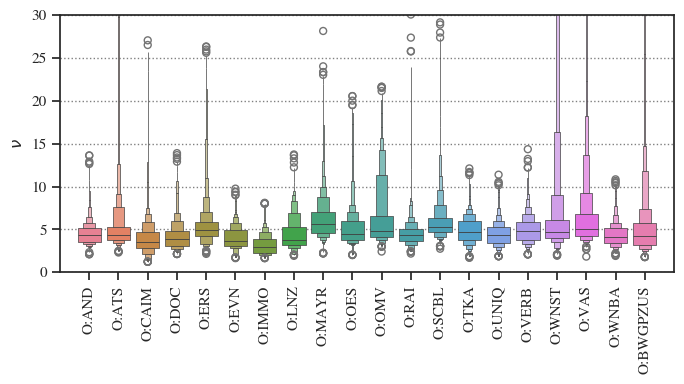

In [720]:
#Letter Value plot vgl. Hormann et al. (2011)
#letter values 50%,25%,12.5%,6.25%,... 

fig, ax = plt.subplots(figsize=(7,4))
sns.boxenplot(df_dist_f_params_nu,ax=ax,linewidth=0.5)
plt.xticks(rotation=90)
ax.set_ylim(0,30)
ax.set_ylabel(r"$\nu$")
ax.set_xlim(left=-1,right=len(df_dist_f_params_nu.columns))
plt.tight_layout()
#fig.savefig("assets/nu_distribution.svg")

plt.show()